### Importe de librerias 


In [1]:
#Para poner la barra de progreso durante el entrenamiento 
!pip install tqdm
import sys
!"{sys.executable}" -m pip install tqdm 

In [2]:
import pennylane as qml
import numpy as np
from pennylane import numpy as pnp
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import random
import pickle

### Definición del dispositivo y número de qubits

Un dispositivo cuántico es un objeto que representa el backend donde se ejecuta el circuito cuántico.

qml.device carga un dispositivo cuántico particular.

'default.qubit':un simulador de estados puros.

'default.mixed':un simulador de estados mezclados.

In [3]:
#Definición del dispositivo cuántico
dev = qml.device("default.mixed", wires=4)

### Arquitectura del Circuito 


Un QNode es una función que contiene al circuito variacional y el dispositivo computacional en el que se ejecuta.

interface="autograd": le dice a PennyLane que los parámetros serán diferenciables con autograd (la librería automática de derivación).

qml.QubitDensityMatrix requiere el estado total del sistema completo.

Toma el estado base (qubits 0 y 1 en |00⟩⟨00|) y lo combina con el estado rho (en qubits 2 y 3) para formar el estado de los 4 qubits juntos.


In [4]:

@qml.qnode(dev) #Decorador para definir el circuito cuántico
def Circuit(params, rho):
    # Crear estado |00⟩⟨00| para qubits 0 y 1
    base = pnp.zeros((4,4), dtype=complex)
    base[0,0] = 1.0 # Para poner la primera entrada de la matriz en 1 y el resto en 0
    
    # Producto tensorial para obtener estado total de 4 qubits
    full_state = pnp.kron(base, rho)
    
    # Usar en el dispositivo de 4 qubits
    qml.QubitDensityMatrix(full_state, wires=[0, 1, 2, 3])
    
    qml.Rot(params[0], params[1], params[2], wires=0)
    qml.Rot(params[3], params[4], params[5], wires=1)
    qml.Rot(params[6], params[7], params[8], wires=2)
    qml.Rot(params[9], params[10], params[11], wires=3)
    
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[0, 2])
    qml.CNOT(wires=[0, 3])
    qml.CNOT(wires=[3, 0])

    # La compuerta v1 opera si el qubit de control (0) está en |1⟩


    qml.PauliX(wires=0)

    qml.ctrl(qml.Rot(params[12], params[13], params[14], wires=1), control=0)
    qml.ctrl(qml.Rot(params[15], params[16], params[17], wires=2), control=0)
    qml.ctrl(qml.Rot(params[18], params[19], params[20], wires=3), control=0)
        
    
    qml.ctrl(qml.CNOT(wires=[1, 2]), control=0)
    qml.ctrl(qml.CNOT(wires=[1, 3]), control=0)
    qml.ctrl(qml.CNOT(wires=[3, 1]), control=0)

    qml.PauliX(wires=0)

    # La compuerta v2 opera si el qubit de control (0) está en |0⟩


    qml.ctrl(qml.Rot(params[21], params[22], params[23], wires=1), control=0)
    qml.ctrl(qml.Rot(params[24], params[25], params[26], wires=2), control=0)
    qml.ctrl(qml.Rot(params[27], params[28], params[29], wires=3), control=0)
        
    
    qml.ctrl(qml.CNOT(wires=[1, 2]), control=0)
    qml.ctrl(qml.CNOT(wires=[1, 3]), control=0)
    qml.ctrl(qml.CNOT(wires=[3, 1]), control=0)    
    
    return qml.probs(wires=[0, 1]) 



### Definición de las familias 

dtype= complex porque aunque las matrices se definan para parametros a y b reales, 
la evolución del sistema si puede introducir números complejos.

In [5]:
def ρ1(a):
    
    psi1 = pnp.array([np.sqrt(1 - a*a), 0.0, a, 0.0], dtype=complex)
    rho1 = pnp.outer(psi1, psi1.conj())
    return rho1, 1

def ρ2(b):

    psi2 = pnp.array([0.0, np.sqrt(1 - b*b), b, 0.0], dtype=complex)
    psi3 = pnp.array([0.0, -np.sqrt(1 - b*b), b, 0.0], dtype=complex)
    rho2 = 0.5 * np.outer(psi2, psi2.conj()) + 0.5 * np.outer(psi3, psi3.conj())

    return rho2, 2
    

### Conjunto de Datos de Prueba 

Para el caso de la distribución uniforme

In [6]:
np.random.seed(2)
n_test = 10000
data_test = []

# Clase 1: rho1, etiqueta = 1
a_test = np.random.uniform(0, 1, int(n_test/2))
for a in a_test:
    rho, label = ρ1(a)
    data_test.append((rho, label))

# Clase 2: rho2, etiqueta = 2
b_test = np.random.uniform(0, 1, int(n_test/2))
for b in b_test:
    rho, label = ρ2(b)
    data_test.append((rho, label))

### Conjunto de Datos de Entrenamiento 


In [7]:
np.random.seed(90701)
n_samples = 50
data = []

# Familia 1 → usa ρ1(a), etiqueta = 1
a_values = np.random.uniform(0, 1, int(n_samples/2))
for a in a_values:
    rho, label = ρ1(a)  # rho es matriz 4x4, label = 1
    data.append((rho, label))

# Familia 2 → usa ρ2(b), etiqueta = 2
b_values = np.random.uniform(0, 1, int(n_samples/2))
for b in b_values:
    rho, label = ρ2(b)  # rho es matriz 4x4, label = 2
    data.append((rho, label))

# Mezclar y dividir: 80% entrenamiento, 20% validación
data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)

### Función de Pérdida 


In [8]:
# Funciones de pérdida

# Clasificación mínimo error (Probabilidad de inconclusión casi nula)

alpha_err = 10  # penaliza los errores
alpha_inc = 2 # penaliza los resultados inconclusos


# Función de pérdida para una muestra según el label:
# label 1: familia 1 se espera que los outcomes 00 y 10 sean correctos.
# label 2: familia 2 se espera que el outcome 01 sea correcto.

def sample_loss(params, rho, label):
    
    probs = Circuit(params, rho)
    # |00> -> probs[0], |01> -> probs[1], |10> -> probs[2], |11> -> probs[3]
    if label == 1:
        # Familia 1 => éxito: (|00>, |10>), error: |01>, inconcluso: |11>
        p_suc = (probs[0] + probs[2])
        p_err = probs[1]
        p_inc = probs[3]
    else:
        # Familia 2 => éxito: |01>, error: (|00>, |10>), inconcluso: |11>
        p_suc = probs[1]
        p_err = probs[0] + probs[2]
        p_inc = probs[3]
        
    return (
    pnp.abs(p_suc - 1.0)
    + alpha_err * pnp.abs(p_err - 0.0)
    + alpha_inc * pnp.abs(p_inc - 0.0)
    )

# Función global de pérdida que promedia sobre el conjunto de muestras

def loss(params, samples):
    total = pnp.array(0.0, requires_grad=True) #iniciar el acumulador del costo total,
    #asegurar que ese acumulador soporta derivación automática, y permitir que luego PennyLane optimice los parámetros con gradientes.  

    for (rho, label) in samples:
        total = total + sample_loss(params, rho, label)

    avg = total / len(samples)           
    return avg  

In [9]:
def get_probabilities(params, rho, label):
    """Calcula las probabilidades de salida del circuito, dada la matriz de densidad."""
    
    return Circuit(params, rho)


### Evaluación del modelo

In [10]:
def evaluate_model(params, samples):
    """Evalúa tasas promedio de éxito, error e inconcluso en cada familia."""
    
    # Separar por familia
    S1 = [rho for (rho, label) in samples if label == 1]
    S2 = [rho for (rho, label) in samples if label == 2]

    total_suc_1, total_err_1, total_inc_1 = 0, 0, 0
    total_suc_2, total_err_2, total_inc_2 = 0, 0, 0

    for rho in S1:
        probs = get_probabilities(params, rho, 1)
        total_suc_1 += probs[0] + probs[2]  # éxito
        total_err_1 += probs[1]
        total_inc_1 += probs[3]

    for rho in S2:
        probs = get_probabilities(params, rho, 2)
        total_suc_2 += probs[1]             # éxito
        total_err_2 += probs[0] + probs[2]
        total_inc_2 += probs[3]

    # Promedios por familia
    n1, n2 = len(S1), len(S2)
    suc = (total_suc_1 + total_suc_2) / (n1 + n2)
    err = (total_err_1 + total_err_2) / (n1 + n2)
    inc = (total_inc_1 + total_inc_2) / (n1 + n2)

    return suc, err, inc


In [11]:
def get_batches(data, batch_size):
    # Asegurar que batch_size sea al menos 1
    batch_size = max(1, int(batch_size))
    
    # Mezclar los datos
    data_shuffled = random.sample(data, len(data))
    
    # Crear los lotes
    return [data_shuffled[i:i+batch_size] for i in range(0, len(data), batch_size)]


### Entrenamiento del modelo


params, curr_loss = opt.step_and_cost(lambda v: loss(v, data_train), params)

opt: Optimizador
.step_and_cost(...): Método que actualiza los parámetros y devuelve el valor de la función de costo


Calcula el valor de la función de la función de costo (loss(...)) para los parámetros actuales.
Calcula el gradiente de esa función de costo con respecto a los parámetros.
Actualiza los parámetros en la dirección que reduce la función de costo.

Devuelve:

params: los nuevos parámetros después de actualizar.

curr_loss: el valor actual de la función de costo.

La función lambda hace que el optimizador calcule la función de costo con los parámetros v usando el conjunto de datos data_train que ya está fijado.



In [12]:
opt = qml.AdamOptimizer(stepsize=0.01)
n_iter = 1000
batch_size = int(len(data_train)*0.2)
val_batch_size=int(0.2*batch_size)

initial_params = np.random.uniform(0, 2 * np.pi, 30)
params = pnp.array(initial_params, requires_grad=True)

# Early stopping
patience = 100
min_delta = 1e-6
best_val_loss = float('inf')
patience_counter = 0

# Historiales
loss_history = []
val_loss_history = []
train_suc_history = []
train_err_history = []
train_inc_history = []
test_suc_history = []
test_err_history = []
test_inc_history = []

for it in tqdm(range(n_iter), desc="Entrenando"):
    
    # Seleccionar un batch aleatorio de data_train
    batch = random.sample(data_train, batch_size)
    
    # Paso de entrenamiento con el batch
    params, train_loss = opt.step_and_cost(lambda v: loss(v, batch), params)
    
    # Evaluación en validación
    val_batches = get_batches(data_val, val_batch_size)
    val_loss = 0
    for vb in val_batches:
        val_loss += loss(params, vb) * len(vb)
    val_loss /= len(data_val)




    # Early stopping
    if best_val_loss - val_loss > min_delta:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"⏹️ Early stopping en iteración {it+1}. Mejor pérdida de validación: {best_val_loss:.6f}")
        break

    # Evaluación en train y test
    suc_train, err_train, inc_train = evaluate_model(params, data_train)
    suc_test, err_test, inc_test = evaluate_model(params, data_test)

    # Guardar métricas
    loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    train_suc_history.append(suc_train)
    train_err_history.append(err_train)
    train_inc_history.append(inc_train)
    test_suc_history.append(suc_test)
    test_err_history.append(err_test)
    test_inc_history.append(inc_test)

    if (it + 1) % 50 == 0:
        print(f"Iter {it+1:3d}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, "
              f"train_suc={suc_train:.3f}, train_err={err_train:.3f}, train_inc={inc_train:.3f} | "
              f"test_suc={suc_test:.3f}, test_err={err_test:.3f}, test_inc={inc_test:.3f}")

# Final
print("\nParámetros entrenados:")
print(params)

print("\nResultados finales en el conjunto de prueba:")
print(f"  Éxito promedio     = {suc_test:.4f}")
print(f"  Error promedio     = {err_test:.4f}")
print(f"  Inconcluso promedio = {inc_test:.4f}")




Entrenando:   0%|          | 0/1000 [00:00<?, ?it/s]

Entrenando:   0%|          | 1/1000 [07:37<126:54:44, 457.34s/it]

Entrenando:   0%|          | 2/1000 [15:11<126:18:04, 455.60s/it]

Entrenando:   0%|          | 3/1000 [22:44<125:51:40, 454.46s/it]

Entrenando:   0%|          | 4/1000 [30:19<125:46:57, 454.64s/it]

Entrenando:   0%|          | 5/1000 [37:52<125:25:32, 453.80s/it]

Entrenando:   1%|          | 6/1000 [45:26<125:20:44, 453.97s/it]

Entrenando:   1%|          | 7/1000 [53:00<125:15:15, 454.09s/it]

Entrenando:   1%|          | 8/1000 [1:00:33<125:01:01, 453.69s/it]

Entrenando:   1%|          | 9/1000 [1:08:08<124:57:44, 453.95s/it]

Entrenando:   1%|          | 10/1000 [1:15:42<124:54:24, 454.21s/it]

Entrenando:   1%|          | 11/1000 [1:23:16<124:42:20, 453.93s/it]

Entrenando:   1%|          | 12/1000 [1:30:49<124:29:39, 453.62s/it]

Entrenando:   1%|▏         | 13/1000 [1:38:23<124:26:12, 453.87s/it]

Entrenando:   1%|▏         | 14/1000 [1:45:57<124:17:25, 453.80s/it]

Entrenando:   2%|▏         | 15/1000 [1:53:33<124:21:06, 454.48s/it]

Entrenando:   2%|▏         | 16/1000 [2:01:11<124:34:20, 455.75s/it]

Entrenando:   2%|▏         | 17/1000 [2:08:47<124:26:10, 455.72s/it]

Entrenando:   2%|▏         | 18/1000 [2:16:20<124:04:25, 454.85s/it]

Entrenando:   2%|▏         | 19/1000 [2:23:53<123:47:31, 454.28s/it]

Entrenando:   2%|▏         | 20/1000 [2:31:29<123:48:58, 454.84s/it]

Entrenando:   2%|▏         | 21/1000 [2:39:02<123:35:03, 454.45s/it]

Entrenando:   2%|▏         | 22/1000 [2:46:37<123:25:35, 454.33s/it]

Entrenando:   2%|▏         | 23/1000 [2:54:12<123:22:46, 454.62s/it]

Entrenando:   2%|▏         | 24/1000 [3:01:47<123:19:27, 454.88s/it]

Entrenando:   2%|▎         | 25/1000 [3:09:20<122:58:50, 454.08s/it]

Entrenando:   3%|▎         | 26/1000 [3:16:54<122:53:24, 454.21s/it]

Entrenando:   3%|▎         | 27/1000 [3:24:26<122:35:56, 453.60s/it]

Entrenando:   3%|▎         | 28/1000 [3:32:02<122:36:45, 454.12s/it]

Entrenando:   3%|▎         | 29/1000 [3:39:38<122:38:43, 454.71s/it]

Entrenando:   3%|▎         | 30/1000 [3:47:10<122:17:37, 453.87s/it]

Entrenando:   3%|▎         | 31/1000 [3:54:45<122:16:30, 454.27s/it]

Entrenando:   3%|▎         | 32/1000 [4:02:21<122:16:14, 454.73s/it]

Entrenando:   3%|▎         | 33/1000 [4:09:54<122:00:26, 454.22s/it]

Entrenando:   3%|▎         | 34/1000 [4:17:27<121:47:15, 453.87s/it]

Entrenando:   4%|▎         | 35/1000 [4:25:02<121:45:08, 454.21s/it]

Entrenando:   4%|▎         | 36/1000 [4:32:35<121:31:13, 453.81s/it]

Entrenando:   4%|▎         | 37/1000 [4:40:09<121:25:46, 453.94s/it]

Entrenando:   4%|▍         | 38/1000 [4:47:46<121:31:39, 454.78s/it]

Entrenando:   4%|▍         | 39/1000 [4:55:18<121:10:36, 453.94s/it]

Entrenando:   4%|▍         | 40/1000 [5:02:51<120:59:40, 453.73s/it]

Entrenando:   4%|▍         | 41/1000 [5:10:26<121:00:04, 454.23s/it]

Entrenando:   4%|▍         | 42/1000 [5:18:00<120:52:11, 454.21s/it]

Entrenando:   4%|▍         | 43/1000 [5:25:33<120:37:55, 453.79s/it]

Entrenando:   4%|▍         | 44/1000 [5:33:06<120:26:42, 453.56s/it]

Entrenando:   4%|▍         | 45/1000 [5:40:40<120:21:14, 453.69s/it]

Entrenando:   5%|▍         | 46/1000 [5:48:16<120:22:26, 454.24s/it]

Entrenando:   5%|▍         | 47/1000 [5:55:50<120:16:47, 454.36s/it]

Entrenando:   5%|▍         | 48/1000 [6:03:25<120:08:56, 454.35s/it]

Entrenando:   5%|▍         | 49/1000 [6:10:59<119:59:39, 454.24s/it]

Entrenando:   5%|▌         | 50/1000 [6:18:33<119:50:53, 454.16s/it]

Iter  50: train_loss=2.6200, val_loss=4.8247, train_suc=0.471, train_err=0.273, train_inc=0.256 | test_suc=0.430, test_err=0.284, test_inc=0.286


Entrenando:   5%|▌         | 51/1000 [6:26:07<119:45:12, 454.28s/it]

Entrenando:   5%|▌         | 52/1000 [6:33:40<119:32:05, 453.93s/it]

Entrenando:   5%|▌         | 53/1000 [6:41:13<119:20:37, 453.68s/it]

Entrenando:   5%|▌         | 54/1000 [6:48:47<119:10:30, 453.52s/it]

Entrenando:   6%|▌         | 55/1000 [6:56:21<119:06:14, 453.73s/it]

Entrenando:   6%|▌         | 56/1000 [7:03:53<118:53:42, 453.41s/it]

Entrenando:   6%|▌         | 57/1000 [7:11:28<118:50:35, 453.70s/it]

Entrenando:   6%|▌         | 58/1000 [7:19:03<118:50:23, 454.17s/it]

Entrenando:   6%|▌         | 59/1000 [7:26:36<118:35:27, 453.70s/it]

Entrenando:   6%|▌         | 60/1000 [7:34:08<118:23:32, 453.42s/it]

Entrenando:   6%|▌         | 61/1000 [7:41:43<118:20:42, 453.72s/it]

Entrenando:   6%|▌         | 62/1000 [7:49:15<118:05:56, 453.26s/it]

Entrenando:   6%|▋         | 63/1000 [7:56:49<117:59:37, 453.34s/it]

Entrenando:   6%|▋         | 64/1000 [8:04:22<117:51:23, 453.29s/it]

Entrenando:   6%|▋         | 65/1000 [8:11:56<117:50:12, 453.70s/it]

Entrenando:   7%|▋         | 66/1000 [8:19:31<117:45:42, 453.90s/it]

Entrenando:   7%|▋         | 67/1000 [8:27:07<117:47:39, 454.51s/it]

Entrenando:   7%|▋         | 68/1000 [8:34:40<117:34:51, 454.18s/it]

Entrenando:   7%|▋         | 69/1000 [8:42:14<117:25:34, 454.06s/it]

Entrenando:   7%|▋         | 70/1000 [8:49:45<117:05:49, 453.28s/it]

Entrenando:   7%|▋         | 71/1000 [8:57:21<117:07:28, 453.87s/it]

Entrenando:   7%|▋         | 72/1000 [9:04:54<116:58:54, 453.81s/it]

Entrenando:   7%|▋         | 73/1000 [9:12:29<116:57:56, 454.24s/it]

Entrenando:   7%|▋         | 74/1000 [9:20:03<116:45:15, 453.90s/it]

Entrenando:   8%|▊         | 75/1000 [9:27:37<116:38:37, 453.96s/it]

Entrenando:   8%|▊         | 76/1000 [9:35:09<116:21:59, 453.38s/it]

Entrenando:   8%|▊         | 77/1000 [9:42:44<116:21:20, 453.82s/it]

Entrenando:   8%|▊         | 78/1000 [9:50:16<116:08:28, 453.48s/it]

Entrenando:   8%|▊         | 79/1000 [9:57:49<115:57:07, 453.23s/it]

Entrenando:   8%|▊         | 80/1000 [10:05:21<115:45:57, 453.00s/it]

Entrenando:   8%|▊         | 81/1000 [10:12:56<115:44:44, 453.41s/it]

Entrenando:   8%|▊         | 82/1000 [10:20:28<115:32:26, 453.10s/it]

Entrenando:   8%|▊         | 83/1000 [10:28:04<115:35:50, 453.82s/it]

Entrenando:   8%|▊         | 84/1000 [10:35:39<115:33:54, 454.19s/it]

Entrenando:   8%|▊         | 85/1000 [10:43:11<115:17:44, 453.62s/it]

Entrenando:   9%|▊         | 86/1000 [10:50:44<115:06:25, 453.38s/it]

Entrenando:   9%|▊         | 87/1000 [10:58:16<114:55:48, 453.18s/it]

Entrenando:   9%|▉         | 88/1000 [11:05:52<115:00:51, 454.00s/it]

Entrenando:   9%|▉         | 89/1000 [11:13:27<114:58:07, 454.32s/it]

Entrenando:   9%|▉         | 90/1000 [11:21:00<114:42:30, 453.79s/it]

Entrenando:   9%|▉         | 91/1000 [11:28:34<114:37:33, 453.96s/it]

Entrenando:   9%|▉         | 92/1000 [11:36:10<114:39:38, 454.60s/it]

Entrenando:   9%|▉         | 93/1000 [11:43:43<114:24:10, 454.08s/it]

Entrenando:   9%|▉         | 94/1000 [11:51:17<114:14:24, 453.93s/it]

Entrenando:  10%|▉         | 95/1000 [11:58:52<114:13:42, 454.39s/it]

Entrenando:  10%|▉         | 96/1000 [12:06:26<114:02:22, 454.14s/it]

Entrenando:  10%|▉         | 97/1000 [12:13:59<113:51:54, 453.95s/it]

Entrenando:  10%|▉         | 98/1000 [12:21:36<113:55:12, 454.67s/it]

Entrenando:  10%|▉         | 99/1000 [12:29:10<113:45:20, 454.52s/it]

Entrenando:  10%|█         | 100/1000 [12:36:42<113:24:56, 453.66s/it]

Iter 100: train_loss=3.7357, val_loss=3.7718, train_suc=0.533, train_err=0.210, train_inc=0.257 | test_suc=0.484, test_err=0.206, test_inc=0.310


Entrenando:  10%|█         | 101/1000 [12:44:17<113:26:36, 454.28s/it]

Entrenando:  10%|█         | 102/1000 [12:51:52<113:22:09, 454.49s/it]

Entrenando:  10%|█         | 103/1000 [12:59:27<113:17:17, 454.67s/it]

Entrenando:  10%|█         | 104/1000 [13:07:01<113:04:53, 454.35s/it]

Entrenando:  10%|█         | 105/1000 [13:14:37<113:05:07, 454.87s/it]

Entrenando:  11%|█         | 106/1000 [13:22:12<112:55:45, 454.75s/it]

Entrenando:  11%|█         | 107/1000 [13:29:48<112:55:27, 455.24s/it]

Entrenando:  11%|█         | 108/1000 [13:37:24<112:50:55, 455.44s/it]

Entrenando:  11%|█         | 109/1000 [13:45:02<112:56:26, 456.33s/it]

Entrenando:  11%|█         | 110/1000 [13:52:37<112:39:59, 455.73s/it]

Entrenando:  11%|█         | 111/1000 [14:00:12<112:30:38, 455.61s/it]

Entrenando:  11%|█         | 112/1000 [14:07:45<112:12:41, 454.91s/it]

Entrenando:  11%|█▏        | 113/1000 [14:15:19<112:01:15, 454.65s/it]

Entrenando:  11%|█▏        | 114/1000 [14:22:56<112:02:19, 455.24s/it]

Entrenando:  12%|█▏        | 115/1000 [14:30:30<111:51:28, 455.02s/it]

Entrenando:  12%|█▏        | 116/1000 [14:38:06<111:48:36, 455.34s/it]

Entrenando:  12%|█▏        | 117/1000 [14:45:41<111:36:34, 455.03s/it]

Entrenando:  12%|█▏        | 118/1000 [14:53:17<111:33:17, 455.33s/it]

Entrenando:  12%|█▏        | 119/1000 [15:00:50<111:18:40, 454.85s/it]

Entrenando:  12%|█▏        | 120/1000 [15:08:27<111:19:35, 455.43s/it]

Entrenando:  12%|█▏        | 121/1000 [15:16:03<111:14:37, 455.61s/it]

Entrenando:  12%|█▏        | 122/1000 [15:23:39<111:07:26, 455.63s/it]

Entrenando:  12%|█▏        | 123/1000 [15:31:13<110:52:09, 455.11s/it]

Entrenando:  12%|█▏        | 124/1000 [15:38:50<110:53:47, 455.74s/it]

Entrenando:  12%|█▎        | 125/1000 [15:46:25<110:41:21, 455.41s/it]

Entrenando:  13%|█▎        | 126/1000 [15:53:59<110:30:38, 455.19s/it]

Entrenando:  13%|█▎        | 127/1000 [16:01:37<110:31:41, 455.79s/it]

Entrenando:  13%|█▎        | 128/1000 [16:09:12<110:21:04, 455.58s/it]

Entrenando:  13%|█▎        | 129/1000 [16:16:47<110:11:18, 455.43s/it]

Entrenando:  13%|█▎        | 130/1000 [16:24:24<110:10:59, 455.93s/it]

Entrenando:  13%|█▎        | 131/1000 [16:31:59<110:00:48, 455.75s/it]

Entrenando:  13%|█▎        | 132/1000 [16:39:34<109:50:30, 455.57s/it]

Entrenando:  13%|█▎        | 133/1000 [16:47:10<109:44:23, 455.67s/it]

Entrenando:  13%|█▎        | 134/1000 [16:54:46<109:36:56, 455.68s/it]

Entrenando:  14%|█▎        | 135/1000 [17:02:21<109:27:17, 455.54s/it]

Entrenando:  14%|█▎        | 136/1000 [17:09:55<109:12:20, 455.02s/it]

Entrenando:  14%|█▎        | 137/1000 [17:17:30<109:03:12, 454.92s/it]

Entrenando:  14%|█▍        | 138/1000 [17:25:03<108:49:40, 454.50s/it]

Entrenando:  14%|█▍        | 139/1000 [17:32:37<108:40:23, 454.38s/it]

Entrenando:  14%|█▍        | 140/1000 [17:40:12<108:33:18, 454.42s/it]

Entrenando:  14%|█▍        | 141/1000 [17:47:49<108:38:08, 455.28s/it]

Entrenando:  14%|█▍        | 142/1000 [17:55:23<108:23:42, 454.81s/it]

Entrenando:  14%|█▍        | 143/1000 [18:02:56<108:08:09, 454.25s/it]

Entrenando:  14%|█▍        | 144/1000 [18:10:31<108:05:10, 454.57s/it]

Entrenando:  14%|█▍        | 145/1000 [18:18:06<107:58:14, 454.61s/it]

Entrenando:  15%|█▍        | 146/1000 [18:25:40<107:48:10, 454.44s/it]

Entrenando:  15%|█▍        | 147/1000 [18:33:17<107:50:34, 455.14s/it]

Entrenando:  15%|█▍        | 148/1000 [18:40:52<107:44:47, 455.27s/it]

Entrenando:  15%|█▍        | 149/1000 [18:48:27<107:34:20, 455.07s/it]

Entrenando:  15%|█▌        | 150/1000 [18:56:01<107:24:33, 454.91s/it]

Iter 150: train_loss=1.9963, val_loss=3.2585, train_suc=0.554, train_err=0.183, train_inc=0.263 | test_suc=0.504, test_err=0.170, test_inc=0.326


Entrenando:  15%|█▌        | 151/1000 [19:03:36<107:17:29, 454.95s/it]

Entrenando:  15%|█▌        | 152/1000 [19:11:12<107:11:19, 455.05s/it]

Entrenando:  15%|█▌        | 153/1000 [19:18:45<106:55:15, 454.45s/it]

Entrenando:  15%|█▌        | 154/1000 [19:26:19<106:45:31, 454.29s/it]

Entrenando:  16%|█▌        | 155/1000 [19:33:53<106:39:34, 454.41s/it]

Entrenando:  16%|█▌        | 156/1000 [19:41:28<106:35:14, 454.64s/it]

Entrenando:  16%|█▌        | 157/1000 [19:49:03<106:26:19, 454.54s/it]

Entrenando:  16%|█▌        | 158/1000 [19:56:38<106:21:57, 454.77s/it]

Entrenando:  16%|█▌        | 159/1000 [20:04:15<106:23:47, 455.44s/it]

Entrenando:  16%|█▌        | 160/1000 [20:11:49<106:10:05, 455.01s/it]

Entrenando:  16%|█▌        | 161/1000 [20:19:24<106:01:51, 454.96s/it]

Entrenando:  16%|█▌        | 162/1000 [20:27:01<106:01:38, 455.49s/it]

Entrenando:  16%|█▋        | 163/1000 [20:34:36<105:54:52, 455.55s/it]

Entrenando:  16%|█▋        | 164/1000 [20:42:12<105:49:12, 455.69s/it]

Entrenando:  16%|█▋        | 165/1000 [20:49:46<105:33:17, 455.09s/it]

Entrenando:  17%|█▋        | 166/1000 [20:57:20<105:21:58, 454.82s/it]

Entrenando:  17%|█▋        | 167/1000 [21:04:57<105:23:57, 455.51s/it]

Entrenando:  17%|█▋        | 168/1000 [21:12:33<105:16:47, 455.54s/it]

Entrenando:  17%|█▋        | 169/1000 [21:20:09<105:13:22, 455.84s/it]

Entrenando:  17%|█▋        | 170/1000 [21:27:43<104:58:28, 455.31s/it]

Entrenando:  17%|█▋        | 171/1000 [21:35:21<104:58:52, 455.89s/it]

Entrenando:  17%|█▋        | 172/1000 [21:42:54<104:42:09, 455.23s/it]

Entrenando:  17%|█▋        | 173/1000 [21:50:31<104:40:26, 455.65s/it]

Entrenando:  17%|█▋        | 174/1000 [21:58:07<104:32:54, 455.66s/it]

Entrenando:  18%|█▊        | 175/1000 [22:05:42<104:23:20, 455.52s/it]

Entrenando:  18%|█▊        | 176/1000 [22:13:18<104:17:10, 455.62s/it]

Entrenando:  18%|█▊        | 177/1000 [22:20:51<104:01:26, 455.03s/it]

Entrenando:  18%|█▊        | 178/1000 [22:28:26<103:52:00, 454.89s/it]

Entrenando:  18%|█▊        | 179/1000 [22:36:01<103:43:49, 454.85s/it]

Entrenando:  18%|█▊        | 180/1000 [22:43:36<103:39:20, 455.07s/it]

Entrenando:  18%|█▊        | 181/1000 [22:51:11<103:29:10, 454.88s/it]

Entrenando:  18%|█▊        | 182/1000 [22:58:48<103:32:05, 455.65s/it]

Entrenando:  18%|█▊        | 183/1000 [23:06:22<103:16:45, 455.09s/it]

Entrenando:  18%|█▊        | 184/1000 [23:13:56<103:02:58, 454.63s/it]

Entrenando:  18%|█▊        | 185/1000 [23:21:30<102:55:51, 454.66s/it]

Entrenando:  19%|█▊        | 186/1000 [23:29:06<102:53:37, 455.06s/it]

Entrenando:  19%|█▊        | 187/1000 [23:36:42<102:47:21, 455.16s/it]

Entrenando:  19%|█▉        | 188/1000 [23:44:16<102:35:17, 454.82s/it]

Entrenando:  19%|█▉        | 189/1000 [23:51:51<102:30:49, 455.05s/it]

Entrenando:  19%|█▉        | 190/1000 [23:59:27<102:25:26, 455.22s/it]

Entrenando:  19%|█▉        | 191/1000 [24:07:04<102:26:37, 455.87s/it]

Entrenando:  19%|█▉        | 192/1000 [24:14:39<102:15:16, 455.59s/it]

Entrenando:  19%|█▉        | 193/1000 [24:22:14<102:06:08, 455.47s/it]

Entrenando:  19%|█▉        | 194/1000 [24:29:49<101:55:57, 455.28s/it]

Entrenando:  20%|█▉        | 195/1000 [24:37:24<101:45:11, 455.04s/it]

Entrenando:  20%|█▉        | 196/1000 [24:44:59<101:38:59, 455.15s/it]

Entrenando:  20%|█▉        | 197/1000 [24:52:34<101:30:59, 455.12s/it]

Entrenando:  20%|█▉        | 198/1000 [25:00:08<101:20:03, 454.87s/it]

Entrenando:  20%|█▉        | 199/1000 [25:07:44<101:15:23, 455.09s/it]

Entrenando:  20%|██        | 200/1000 [25:15:20<101:09:10, 455.19s/it]

Iter 200: train_loss=3.5037, val_loss=3.1807, train_suc=0.562, train_err=0.177, train_inc=0.261 | test_suc=0.511, test_err=0.165, test_inc=0.324


Entrenando:  20%|██        | 201/1000 [25:22:54<100:58:00, 454.92s/it]

Entrenando:  20%|██        | 202/1000 [25:30:27<100:44:47, 454.50s/it]

Entrenando:  20%|██        | 203/1000 [25:38:03<100:42:22, 454.88s/it]

Entrenando:  20%|██        | 204/1000 [25:45:37<100:30:52, 454.59s/it]

Entrenando:  20%|██        | 205/1000 [25:53:13<100:28:27, 454.98s/it]

Entrenando:  21%|██        | 206/1000 [26:00:47<100:17:48, 454.75s/it]

Entrenando:  21%|██        | 207/1000 [26:08:22<100:09:38, 454.70s/it]

Entrenando:  21%|██        | 208/1000 [26:15:56<99:59:59, 454.55s/it] 

Entrenando:  21%|██        | 209/1000 [26:23:29<99:45:18, 454.01s/it]

Entrenando:  21%|██        | 210/1000 [26:31:03<99:40:30, 454.22s/it]

Entrenando:  21%|██        | 211/1000 [26:38:37<99:30:19, 454.02s/it]

Entrenando:  21%|██        | 212/1000 [26:46:14<99:36:19, 455.05s/it]

Entrenando:  21%|██▏       | 213/1000 [26:53:48<99:24:22, 454.72s/it]

Entrenando:  21%|██▏       | 214/1000 [27:01:22<99:13:11, 454.44s/it]

Entrenando:  22%|██▏       | 215/1000 [27:08:57<99:07:35, 454.59s/it]

Entrenando:  22%|██▏       | 216/1000 [27:16:32<99:03:20, 454.85s/it]

Entrenando:  22%|██▏       | 217/1000 [27:24:09<99:01:07, 455.26s/it]

Entrenando:  22%|██▏       | 218/1000 [27:31:47<99:05:02, 456.14s/it]

Entrenando:  22%|██▏       | 219/1000 [27:39:23<98:58:42, 456.24s/it]

Entrenando:  22%|██▏       | 220/1000 [27:46:58<98:45:04, 455.78s/it]

Entrenando:  22%|██▏       | 221/1000 [27:54:34<98:36:28, 455.70s/it]

Entrenando:  22%|██▏       | 222/1000 [28:02:08<98:25:40, 455.45s/it]

Entrenando:  22%|██▏       | 223/1000 [28:09:47<98:30:50, 456.44s/it]

Entrenando:  22%|██▏       | 224/1000 [28:17:21<98:13:01, 455.65s/it]

Entrenando:  22%|██▎       | 225/1000 [28:24:56<98:04:49, 455.60s/it]

Entrenando:  23%|██▎       | 226/1000 [28:32:31<97:53:38, 455.32s/it]

Entrenando:  23%|██▎       | 227/1000 [28:40:07<97:49:36, 455.60s/it]

Entrenando:  23%|██▎       | 228/1000 [28:47:41<97:34:50, 455.04s/it]

Entrenando:  23%|██▎       | 229/1000 [28:55:17<97:30:33, 455.30s/it]

Entrenando:  23%|██▎       | 230/1000 [29:02:51<97:19:02, 454.99s/it]

Entrenando:  23%|██▎       | 231/1000 [29:10:26<97:09:47, 454.86s/it]

Entrenando:  23%|██▎       | 232/1000 [29:18:00<96:59:29, 454.65s/it]

Entrenando:  23%|██▎       | 233/1000 [29:25:33<96:45:12, 454.12s/it]

Entrenando:  23%|██▎       | 234/1000 [29:33:08<96:39:34, 454.27s/it]

Entrenando:  24%|██▎       | 235/1000 [29:40:42<96:33:12, 454.37s/it]

Entrenando:  24%|██▎       | 236/1000 [29:48:19<96:36:55, 455.26s/it]

Entrenando:  24%|██▎       | 237/1000 [29:55:55<96:30:50, 455.37s/it]

Entrenando:  24%|██▍       | 238/1000 [30:03:29<96:19:32, 455.08s/it]

Entrenando:  24%|██▍       | 239/1000 [30:11:02<96:01:36, 454.27s/it]

Entrenando:  24%|██▍       | 240/1000 [30:18:38<96:02:57, 454.97s/it]

Entrenando:  24%|██▍       | 241/1000 [30:26:14<95:59:17, 455.28s/it]

Entrenando:  24%|██▍       | 242/1000 [30:33:51<95:54:58, 455.54s/it]

Entrenando:  24%|██▍       | 243/1000 [30:41:28<95:54:46, 456.13s/it]

Entrenando:  24%|██▍       | 244/1000 [30:49:03<95:40:56, 455.63s/it]

Entrenando:  24%|██▍       | 245/1000 [30:56:38<95:32:07, 455.53s/it]

Entrenando:  25%|██▍       | 246/1000 [31:04:14<95:28:34, 455.86s/it]

Entrenando:  25%|██▍       | 247/1000 [31:11:50<95:21:33, 455.90s/it]

Entrenando:  25%|██▍       | 248/1000 [31:19:26<95:13:33, 455.87s/it]

Entrenando:  25%|██▍       | 249/1000 [31:27:01<95:02:26, 455.59s/it]

Entrenando:  25%|██▌       | 250/1000 [31:34:35<94:46:41, 454.94s/it]

Iter 250: train_loss=2.3241, val_loss=3.0111, train_suc=0.575, train_err=0.166, train_inc=0.259 | test_suc=0.524, test_err=0.154, test_inc=0.322


Entrenando:  25%|██▌       | 251/1000 [31:42:09<94:38:32, 454.89s/it]

Entrenando:  25%|██▌       | 252/1000 [31:49:45<94:34:59, 455.21s/it]

Entrenando:  25%|██▌       | 253/1000 [31:57:23<94:37:24, 456.02s/it]

Entrenando:  25%|██▌       | 254/1000 [32:04:59<94:28:01, 455.87s/it]

Entrenando:  26%|██▌       | 255/1000 [32:12:36<94:25:14, 456.26s/it]

Entrenando:  26%|██▌       | 256/1000 [32:20:11<94:11:25, 455.76s/it]

Entrenando:  26%|██▌       | 257/1000 [32:27:46<94:03:59, 455.77s/it]

Entrenando:  26%|██▌       | 258/1000 [32:35:21<93:50:48, 455.32s/it]

Entrenando:  26%|██▌       | 259/1000 [32:42:56<93:43:25, 455.34s/it]

Entrenando:  26%|██▌       | 260/1000 [32:50:35<93:47:33, 456.29s/it]

Entrenando:  26%|██▌       | 261/1000 [32:58:10<93:36:19, 455.99s/it]

Entrenando:  26%|██▌       | 262/1000 [33:05:46<93:27:56, 455.93s/it]

Entrenando:  26%|██▋       | 263/1000 [33:13:20<93:15:20, 455.52s/it]

Entrenando:  26%|██▋       | 264/1000 [33:20:55<93:06:20, 455.41s/it]

Entrenando:  26%|██▋       | 265/1000 [33:28:33<93:05:50, 455.99s/it]

Entrenando:  27%|██▋       | 266/1000 [33:36:09<93:00:04, 456.14s/it]

Entrenando:  27%|██▋       | 267/1000 [33:43:45<92:53:09, 456.19s/it]

Entrenando:  27%|██▋       | 268/1000 [33:51:23<92:50:09, 456.57s/it]

Entrenando:  27%|██▋       | 269/1000 [33:58:58<92:37:37, 456.17s/it]

Entrenando:  27%|██▋       | 270/1000 [34:06:32<92:21:40, 455.48s/it]

Entrenando:  27%|██▋       | 271/1000 [34:14:07<92:11:32, 455.27s/it]

Entrenando:  27%|██▋       | 272/1000 [34:21:42<92:04:53, 455.35s/it]

Entrenando:  27%|██▋       | 273/1000 [34:29:17<91:54:19, 455.10s/it]

Entrenando:  27%|██▋       | 274/1000 [34:36:54<91:52:48, 455.60s/it]

Entrenando:  28%|██▊       | 275/1000 [34:44:28<91:40:12, 455.19s/it]

Entrenando:  28%|██▊       | 276/1000 [34:52:02<91:29:33, 454.94s/it]

Entrenando:  28%|██▊       | 277/1000 [34:59:38<91:26:28, 455.31s/it]

Entrenando:  28%|██▊       | 278/1000 [35:07:15<91:21:47, 455.55s/it]

Entrenando:  28%|██▊       | 279/1000 [35:14:52<91:22:03, 456.20s/it]

Entrenando:  28%|██▊       | 280/1000 [35:22:26<91:04:40, 455.39s/it]

Entrenando:  28%|██▊       | 281/1000 [35:30:02<91:01:20, 455.75s/it]

Entrenando:  28%|██▊       | 282/1000 [35:37:37<90:50:19, 455.46s/it]

Entrenando:  28%|██▊       | 283/1000 [35:45:13<90:46:03, 455.74s/it]

Entrenando:  28%|██▊       | 284/1000 [35:52:47<90:31:19, 455.14s/it]

Entrenando:  28%|██▊       | 285/1000 [36:00:24<90:29:06, 455.59s/it]

Entrenando:  29%|██▊       | 286/1000 [36:08:00<90:22:01, 455.63s/it]

Entrenando:  29%|██▊       | 287/1000 [36:15:35<90:13:33, 455.56s/it]

Entrenando:  29%|██▉       | 288/1000 [36:23:10<90:04:34, 455.44s/it]

Entrenando:  29%|██▉       | 289/1000 [36:30:47<90:03:28, 455.99s/it]

Entrenando:  29%|██▉       | 290/1000 [36:38:24<89:58:49, 456.24s/it]

Entrenando:  29%|██▉       | 291/1000 [36:45:59<89:46:51, 455.87s/it]

Entrenando:  29%|██▉       | 292/1000 [36:53:36<89:41:10, 456.03s/it]

Entrenando:  29%|██▉       | 293/1000 [37:01:11<89:29:54, 455.72s/it]

Entrenando:  29%|██▉       | 294/1000 [37:08:46<89:21:55, 455.69s/it]

Entrenando:  30%|██▉       | 295/1000 [37:16:24<89:20:59, 456.25s/it]

Entrenando:  30%|██▉       | 296/1000 [37:24:00<89:11:36, 456.10s/it]

Entrenando:  30%|██▉       | 297/1000 [37:31:35<89:00:33, 455.81s/it]

Entrenando:  30%|██▉       | 298/1000 [37:39:10<88:49:23, 455.50s/it]

Entrenando:  30%|██▉       | 299/1000 [37:46:45<88:41:17, 455.46s/it]

Entrenando:  30%|███       | 300/1000 [37:54:20<88:32:49, 455.39s/it]

Iter 300: train_loss=2.6195, val_loss=2.8301, train_suc=0.590, train_err=0.154, train_inc=0.256 | test_suc=0.538, test_err=0.144, test_inc=0.318


Entrenando:  30%|███       | 301/1000 [38:01:55<88:23:05, 455.20s/it]

Entrenando:  30%|███       | 302/1000 [38:09:30<88:14:11, 455.09s/it]

Entrenando:  30%|███       | 303/1000 [38:17:04<88:05:42, 455.01s/it]

Entrenando:  30%|███       | 304/1000 [38:24:39<87:55:30, 454.78s/it]

Entrenando:  30%|███       | 305/1000 [38:32:16<87:55:21, 455.43s/it]

Entrenando:  31%|███       | 306/1000 [38:39:52<87:51:32, 455.75s/it]

Entrenando:  31%|███       | 307/1000 [38:47:29<87:49:11, 456.21s/it]

Entrenando:  31%|███       | 308/1000 [38:55:03<87:34:04, 455.56s/it]

Entrenando:  31%|███       | 309/1000 [39:02:41<87:32:01, 456.04s/it]

Entrenando:  31%|███       | 310/1000 [39:10:13<87:11:31, 454.91s/it]

Entrenando:  31%|███       | 311/1000 [39:17:48<87:04:06, 454.93s/it]

Entrenando:  31%|███       | 312/1000 [39:25:21<86:50:40, 454.42s/it]

Entrenando:  31%|███▏      | 313/1000 [39:32:56<86:44:41, 454.56s/it]

Entrenando:  31%|███▏      | 314/1000 [39:40:32<86:43:01, 455.07s/it]

Entrenando:  32%|███▏      | 315/1000 [39:48:10<86:45:05, 455.92s/it]

Entrenando:  32%|███▏      | 316/1000 [39:55:45<86:32:30, 455.48s/it]

Entrenando:  32%|███▏      | 317/1000 [40:03:20<86:24:30, 455.45s/it]

Entrenando:  32%|███▏      | 318/1000 [40:10:54<86:12:50, 455.09s/it]

Entrenando:  32%|███▏      | 319/1000 [40:18:30<86:07:18, 455.27s/it]

Entrenando:  32%|███▏      | 320/1000 [40:26:06<86:01:59, 455.47s/it]

Entrenando:  32%|███▏      | 321/1000 [40:33:44<86:01:36, 456.11s/it]

Entrenando:  32%|███▏      | 322/1000 [40:41:18<85:49:16, 455.69s/it]

Entrenando:  32%|███▏      | 323/1000 [40:48:53<85:37:59, 455.36s/it]

Entrenando:  32%|███▏      | 324/1000 [40:56:30<85:36:09, 455.87s/it]

Entrenando:  32%|███▎      | 325/1000 [41:04:06<85:30:22, 456.03s/it]

Entrenando:  33%|███▎      | 326/1000 [41:11:41<85:17:59, 455.61s/it]

Entrenando:  33%|███▎      | 327/1000 [41:19:15<85:06:26, 455.25s/it]

Entrenando:  33%|███▎      | 328/1000 [41:26:50<84:56:22, 455.03s/it]

Entrenando:  33%|███▎      | 329/1000 [41:34:25<84:49:45, 455.12s/it]

Entrenando:  33%|███▎      | 330/1000 [41:42:00<84:41:48, 455.09s/it]

Entrenando:  33%|███▎      | 331/1000 [41:49:36<84:37:23, 455.37s/it]

Entrenando:  33%|███▎      | 332/1000 [41:57:12<84:29:47, 455.37s/it]

Entrenando:  33%|███▎      | 333/1000 [42:04:47<84:21:03, 455.27s/it]

Entrenando:  33%|███▎      | 334/1000 [42:12:22<84:12:32, 455.18s/it]

Entrenando:  34%|███▎      | 335/1000 [42:19:59<84:12:12, 455.84s/it]

Entrenando:  34%|███▎      | 336/1000 [42:27:35<84:04:10, 455.80s/it]

Entrenando:  34%|███▎      | 337/1000 [42:35:10<83:55:50, 455.73s/it]

Entrenando:  34%|███▍      | 338/1000 [42:42:47<83:50:38, 455.95s/it]

Entrenando:  34%|███▍      | 339/1000 [42:50:23<83:44:53, 456.12s/it]

Entrenando:  34%|███▍      | 340/1000 [42:57:58<83:33:21, 455.76s/it]

Entrenando:  34%|███▍      | 341/1000 [43:05:34<83:27:11, 455.89s/it]

Entrenando:  34%|███▍      | 342/1000 [43:13:12<83:24:08, 456.30s/it]

Entrenando:  34%|███▍      | 343/1000 [43:20:46<83:10:54, 455.79s/it]

Entrenando:  34%|███▍      | 344/1000 [43:28:21<82:59:17, 455.42s/it]

Entrenando:  34%|███▍      | 345/1000 [43:35:57<82:53:27, 455.58s/it]

Entrenando:  35%|███▍      | 346/1000 [43:43:35<82:54:57, 456.42s/it]

Entrenando:  35%|███▍      | 347/1000 [43:51:10<82:43:01, 456.02s/it]

Entrenando:  35%|███▍      | 348/1000 [43:58:45<82:32:53, 455.79s/it]

Entrenando:  35%|███▍      | 349/1000 [44:06:22<82:28:58, 456.13s/it]

Entrenando:  35%|███▌      | 350/1000 [44:13:56<82:14:52, 455.53s/it]

Iter 350: train_loss=1.5275, val_loss=2.7968, train_suc=0.600, train_err=0.149, train_inc=0.251 | test_suc=0.547, test_err=0.141, test_inc=0.311


Entrenando:  35%|███▌      | 351/1000 [44:21:31<82:04:00, 455.22s/it]

Entrenando:  35%|███▌      | 352/1000 [44:29:06<81:55:24, 455.13s/it]

Entrenando:  35%|███▌      | 353/1000 [44:36:42<81:51:59, 455.52s/it]

Entrenando:  35%|███▌      | 354/1000 [44:44:17<81:41:29, 455.25s/it]

Entrenando:  36%|███▌      | 355/1000 [44:51:52<81:34:07, 455.27s/it]

Entrenando:  36%|███▌      | 356/1000 [44:59:29<81:30:32, 455.64s/it]

Entrenando:  36%|███▌      | 357/1000 [45:07:04<81:20:26, 455.41s/it]

Entrenando:  36%|███▌      | 358/1000 [45:14:39<81:13:30, 455.47s/it]

Entrenando:  36%|███▌      | 359/1000 [45:22:14<81:05:04, 455.39s/it]

Entrenando:  36%|███▌      | 360/1000 [45:29:49<80:53:32, 455.02s/it]

Entrenando:  36%|███▌      | 361/1000 [45:37:26<80:52:17, 455.61s/it]

Entrenando:  36%|███▌      | 362/1000 [45:45:00<80:39:59, 455.17s/it]

Entrenando:  36%|███▋      | 363/1000 [45:52:36<80:34:35, 455.38s/it]

Entrenando:  36%|███▋      | 364/1000 [46:00:11<80:26:20, 455.32s/it]

Entrenando:  36%|███▋      | 365/1000 [46:07:48<80:24:32, 455.86s/it]

Entrenando:  37%|███▋      | 366/1000 [46:15:24<80:18:18, 455.99s/it]

Entrenando:  37%|███▋      | 367/1000 [46:23:02<80:15:28, 456.44s/it]

Entrenando:  37%|███▋      | 368/1000 [46:30:39<80:09:56, 456.64s/it]

Entrenando:  37%|███▋      | 369/1000 [46:38:15<80:00:56, 456.51s/it]

Entrenando:  37%|███▋      | 370/1000 [46:45:50<79:48:22, 456.04s/it]

Entrenando:  37%|███▋      | 371/1000 [46:53:26<79:40:46, 456.04s/it]

Entrenando:  37%|███▋      | 372/1000 [47:01:02<79:32:46, 456.00s/it]

Entrenando:  37%|███▋      | 373/1000 [47:08:37<79:21:26, 455.64s/it]

Entrenando:  37%|███▋      | 374/1000 [47:16:11<79:09:02, 455.18s/it]

Entrenando:  38%|███▊      | 375/1000 [47:23:45<78:59:33, 455.00s/it]

Entrenando:  38%|███▊      | 376/1000 [47:31:21<78:54:22, 455.23s/it]

Entrenando:  38%|███▊      | 377/1000 [47:38:56<78:45:16, 455.08s/it]

Entrenando:  38%|███▊      | 378/1000 [47:46:31<78:38:21, 455.15s/it]

Entrenando:  38%|███▊      | 379/1000 [47:54:05<78:25:19, 454.62s/it]

Entrenando:  38%|███▊      | 380/1000 [48:01:42<78:25:18, 455.35s/it]

Entrenando:  38%|███▊      | 381/1000 [48:09:15<78:12:34, 454.85s/it]

Entrenando:  38%|███▊      | 382/1000 [48:16:51<78:07:30, 455.10s/it]

Entrenando:  38%|███▊      | 383/1000 [48:24:26<78:00:50, 455.19s/it]

Entrenando:  38%|███▊      | 384/1000 [48:32:01<77:52:54, 455.15s/it]

Entrenando:  38%|███▊      | 385/1000 [48:39:36<77:42:36, 454.89s/it]

Entrenando:  39%|███▊      | 386/1000 [48:47:10<77:33:44, 454.76s/it]

Entrenando:  39%|███▊      | 387/1000 [48:54:45<77:25:42, 454.72s/it]

Entrenando:  39%|███▉      | 388/1000 [49:02:20<77:18:18, 454.74s/it]

Entrenando:  39%|███▉      | 389/1000 [49:09:57<77:17:30, 455.40s/it]

Entrenando:  39%|███▉      | 390/1000 [49:17:33<77:13:01, 455.71s/it]

Entrenando:  39%|███▉      | 391/1000 [49:25:08<77:02:01, 455.37s/it]

Entrenando:  39%|███▉      | 392/1000 [49:32:43<76:55:42, 455.50s/it]

Entrenando:  39%|███▉      | 393/1000 [49:40:18<76:46:44, 455.36s/it]

Entrenando:  39%|███▉      | 394/1000 [49:47:56<76:45:49, 456.02s/it]

Entrenando:  40%|███▉      | 395/1000 [49:55:34<76:44:13, 456.62s/it]

Entrenando:  40%|███▉      | 396/1000 [50:03:08<76:28:52, 455.85s/it]

Entrenando:  40%|███▉      | 397/1000 [50:10:44<76:20:27, 455.77s/it]

Entrenando:  40%|███▉      | 398/1000 [50:18:17<76:05:38, 455.05s/it]

Entrenando:  40%|███▉      | 399/1000 [50:25:51<75:54:14, 454.67s/it]

Entrenando:  40%|████      | 400/1000 [50:33:29<75:57:42, 455.77s/it]

Iter 400: train_loss=2.2832, val_loss=2.7177, train_suc=0.611, train_err=0.143, train_inc=0.246 | test_suc=0.558, test_err=0.137, test_inc=0.305


Entrenando:  40%|████      | 401/1000 [50:41:04<75:47:04, 455.47s/it]

Entrenando:  40%|████      | 402/1000 [50:48:42<75:47:38, 456.29s/it]

Entrenando:  40%|████      | 403/1000 [50:56:17<75:37:09, 456.00s/it]

Entrenando:  40%|████      | 404/1000 [51:03:52<75:25:32, 455.59s/it]

Entrenando:  40%|████      | 405/1000 [51:11:26<75:11:57, 454.99s/it]

Entrenando:  41%|████      | 406/1000 [51:18:59<75:00:54, 454.64s/it]

Entrenando:  41%|████      | 407/1000 [51:26:33<74:50:41, 454.37s/it]

Entrenando:  41%|████      | 408/1000 [51:34:08<74:43:56, 454.45s/it]

Entrenando:  41%|████      | 409/1000 [51:41:42<74:35:48, 454.40s/it]

Entrenando:  41%|████      | 410/1000 [51:49:17<74:30:57, 454.67s/it]

Entrenando:  41%|████      | 411/1000 [51:56:53<74:25:24, 454.88s/it]

Entrenando:  41%|████      | 412/1000 [52:04:29<74:22:14, 455.33s/it]

Entrenando:  41%|████▏     | 413/1000 [52:12:04<74:14:36, 455.33s/it]

Entrenando:  41%|████▏     | 414/1000 [52:19:39<74:05:02, 455.12s/it]

Entrenando:  42%|████▏     | 415/1000 [52:27:19<74:10:19, 456.44s/it]

Entrenando:  42%|████▏     | 416/1000 [52:34:54<74:00:12, 456.18s/it]

Entrenando:  42%|████▏     | 417/1000 [52:42:30<73:51:25, 456.07s/it]

Entrenando:  42%|████▏     | 418/1000 [52:50:04<73:36:31, 455.31s/it]

Entrenando:  42%|████▏     | 419/1000 [52:57:38<73:25:35, 454.97s/it]

Entrenando:  42%|████▏     | 420/1000 [53:05:10<73:11:32, 454.30s/it]

Entrenando:  42%|████▏     | 421/1000 [53:12:47<73:10:44, 455.00s/it]

Entrenando:  42%|████▏     | 422/1000 [53:20:20<72:58:33, 454.52s/it]

Entrenando:  42%|████▏     | 423/1000 [53:27:53<72:46:01, 454.01s/it]

Entrenando:  42%|████▏     | 424/1000 [53:35:30<72:47:36, 454.96s/it]

Entrenando:  42%|████▎     | 425/1000 [53:43:05<72:38:19, 454.78s/it]

Entrenando:  43%|████▎     | 426/1000 [53:50:38<72:26:28, 454.33s/it]

Entrenando:  43%|████▎     | 427/1000 [53:58:13<72:20:33, 454.51s/it]

Entrenando:  43%|████▎     | 428/1000 [54:05:45<72:06:43, 453.85s/it]

Entrenando:  43%|████▎     | 429/1000 [54:13:20<72:01:39, 454.11s/it]

Entrenando:  43%|████▎     | 430/1000 [54:20:53<71:51:35, 453.85s/it]

Entrenando:  43%|████▎     | 431/1000 [54:28:27<71:43:59, 453.85s/it]

Entrenando:  43%|████▎     | 432/1000 [54:36:02<71:39:08, 454.13s/it]

Entrenando:  43%|████▎     | 433/1000 [54:43:35<71:29:24, 453.91s/it]

Entrenando:  43%|████▎     | 434/1000 [54:51:10<71:23:08, 454.04s/it]

Entrenando:  44%|████▎     | 435/1000 [54:58:47<71:24:26, 454.99s/it]

Entrenando:  44%|████▎     | 436/1000 [55:06:21<71:15:50, 454.88s/it]

Entrenando:  44%|████▎     | 437/1000 [55:13:57<71:11:24, 455.21s/it]

Entrenando:  44%|████▍     | 438/1000 [55:21:31<70:59:51, 454.79s/it]

Entrenando:  44%|████▍     | 439/1000 [55:29:06<70:53:19, 454.90s/it]

Entrenando:  44%|████▍     | 440/1000 [55:36:42<70:46:12, 454.95s/it]

Entrenando:  44%|████▍     | 441/1000 [55:44:16<70:37:08, 454.79s/it]

Entrenando:  44%|████▍     | 442/1000 [55:51:54<70:37:22, 455.63s/it]

Entrenando:  44%|████▍     | 443/1000 [55:59:28<70:25:47, 455.20s/it]

Entrenando:  44%|████▍     | 444/1000 [56:07:04<70:19:53, 455.38s/it]

Entrenando:  44%|████▍     | 445/1000 [56:14:38<70:08:46, 455.00s/it]

Entrenando:  45%|████▍     | 446/1000 [56:22:12<69:58:51, 454.75s/it]

Entrenando:  45%|████▍     | 447/1000 [56:29:46<69:48:33, 454.45s/it]

Entrenando:  45%|████▍     | 448/1000 [56:37:19<69:39:01, 454.24s/it]

Entrenando:  45%|████▍     | 449/1000 [56:44:53<69:30:36, 454.15s/it]

Entrenando:  45%|████▌     | 450/1000 [56:52:28<69:24:02, 454.26s/it]

Iter 450: train_loss=1.8828, val_loss=2.6167, train_suc=0.614, train_err=0.139, train_inc=0.247 | test_suc=0.561, test_err=0.132, test_inc=0.307


Entrenando:  45%|████▌     | 451/1000 [57:00:05<69:25:04, 455.20s/it]

Entrenando:  45%|████▌     | 452/1000 [57:07:39<69:15:05, 454.94s/it]

Entrenando:  45%|████▌     | 453/1000 [57:15:13<69:02:57, 454.44s/it]

Entrenando:  45%|████▌     | 454/1000 [57:22:46<68:52:15, 454.09s/it]

Entrenando:  46%|████▌     | 455/1000 [57:30:22<68:49:32, 454.63s/it]

Entrenando:  46%|████▌     | 456/1000 [57:37:57<68:41:57, 454.63s/it]

Entrenando:  46%|████▌     | 457/1000 [57:45:33<68:38:10, 455.05s/it]

Entrenando:  46%|████▌     | 458/1000 [57:53:07<68:29:22, 454.91s/it]

Entrenando:  46%|████▌     | 459/1000 [58:00:41<68:19:58, 454.71s/it]

Entrenando:  46%|████▌     | 460/1000 [58:08:16<68:12:04, 454.68s/it]

Entrenando:  46%|████▌     | 461/1000 [58:15:50<68:03:17, 454.54s/it]

Entrenando:  46%|████▌     | 462/1000 [58:23:25<67:57:11, 454.71s/it]

Entrenando:  46%|████▋     | 463/1000 [58:31:01<67:51:39, 454.93s/it]

Entrenando:  46%|████▋     | 464/1000 [58:38:39<67:51:33, 455.77s/it]

Entrenando:  46%|████▋     | 465/1000 [58:46:13<67:40:24, 455.37s/it]

Entrenando:  47%|████▋     | 466/1000 [58:53:51<67:40:14, 456.21s/it]

Entrenando:  47%|████▋     | 467/1000 [59:01:26<67:30:04, 455.92s/it]

Entrenando:  47%|████▋     | 468/1000 [59:09:04<67:28:07, 456.56s/it]

Entrenando:  47%|████▋     | 469/1000 [59:16:39<67:14:31, 455.88s/it]

Entrenando:  47%|████▋     | 470/1000 [59:24:13<67:04:00, 455.55s/it]

Entrenando:  47%|████▋     | 471/1000 [59:31:49<66:56:15, 455.53s/it]

Entrenando:  47%|████▋     | 472/1000 [59:39:25<66:49:02, 455.57s/it]

Entrenando:  47%|████▋     | 473/1000 [59:47:01<66:42:40, 455.71s/it]

Entrenando:  47%|████▋     | 474/1000 [59:54:36<66:34:41, 455.67s/it]

Entrenando:  48%|████▊     | 475/1000 [60:02:13<66:28:49, 455.87s/it]

Entrenando:  48%|████▊     | 476/1000 [60:09:48<66:19:43, 455.69s/it]

Entrenando:  48%|████▊     | 477/1000 [60:17:25<66:15:00, 456.02s/it]

Entrenando:  48%|████▊     | 478/1000 [60:24:59<66:01:43, 455.37s/it]

Entrenando:  48%|████▊     | 479/1000 [60:32:34<65:54:43, 455.44s/it]

Entrenando:  48%|████▊     | 480/1000 [60:40:09<65:45:38, 455.27s/it]

Entrenando:  48%|████▊     | 481/1000 [60:47:45<65:40:13, 455.52s/it]

Entrenando:  48%|████▊     | 482/1000 [60:55:18<65:25:27, 454.69s/it]

Entrenando:  48%|████▊     | 483/1000 [61:02:53<65:19:29, 454.87s/it]

Entrenando:  48%|████▊     | 484/1000 [61:10:28<65:11:57, 454.88s/it]

Entrenando:  48%|████▊     | 485/1000 [61:18:04<65:07:36, 455.26s/it]

Entrenando:  49%|████▊     | 486/1000 [61:25:39<64:59:47, 455.23s/it]

Entrenando:  49%|████▊     | 487/1000 [61:33:14<64:51:35, 455.16s/it]

Entrenando:  49%|████▉     | 488/1000 [61:40:49<64:41:49, 454.90s/it]

Entrenando:  49%|████▉     | 489/1000 [61:48:24<64:35:01, 454.99s/it]

Entrenando:  49%|████▉     | 490/1000 [61:55:58<64:25:01, 454.71s/it]

Entrenando:  49%|████▉     | 491/1000 [62:03:33<64:18:58, 454.89s/it]

Entrenando:  49%|████▉     | 492/1000 [62:11:08<64:10:05, 454.74s/it]

Entrenando:  49%|████▉     | 493/1000 [62:18:44<64:05:37, 455.10s/it]

Entrenando:  49%|████▉     | 494/1000 [62:26:18<63:57:07, 455.00s/it]

Entrenando:  50%|████▉     | 495/1000 [62:33:52<63:47:15, 454.72s/it]

Entrenando:  50%|████▉     | 496/1000 [62:41:27<63:40:27, 454.82s/it]

Entrenando:  50%|████▉     | 497/1000 [62:49:02<63:32:12, 454.74s/it]

Entrenando:  50%|████▉     | 498/1000 [62:56:35<63:20:52, 454.29s/it]

Entrenando:  50%|████▉     | 499/1000 [63:04:09<63:12:35, 454.20s/it]

Entrenando:  50%|█████     | 500/1000 [63:11:46<63:11:20, 454.96s/it]

Iter 500: train_loss=2.7136, val_loss=2.5937, train_suc=0.618, train_err=0.137, train_inc=0.245 | test_suc=0.564, test_err=0.131, test_inc=0.305


Entrenando:  50%|█████     | 501/1000 [63:19:22<63:05:24, 455.16s/it]

Entrenando:  50%|█████     | 502/1000 [63:26:57<62:57:34, 455.13s/it]

Entrenando:  50%|█████     | 503/1000 [63:34:31<62:47:07, 454.78s/it]

Entrenando:  50%|█████     | 504/1000 [63:42:06<62:41:24, 455.01s/it]

Entrenando:  50%|█████     | 505/1000 [63:49:43<62:37:40, 455.48s/it]

Entrenando:  51%|█████     | 506/1000 [63:57:19<62:32:00, 455.71s/it]

Entrenando:  51%|█████     | 507/1000 [64:04:54<62:22:37, 455.49s/it]

Entrenando:  51%|█████     | 508/1000 [64:12:29<62:14:56, 455.48s/it]

Entrenando:  51%|█████     | 509/1000 [64:20:03<62:03:55, 455.06s/it]

Entrenando:  51%|█████     | 510/1000 [64:27:39<61:57:50, 455.25s/it]

Entrenando:  51%|█████     | 511/1000 [64:35:13<61:48:05, 454.98s/it]

Entrenando:  51%|█████     | 512/1000 [64:42:49<61:41:22, 455.09s/it]

Entrenando:  51%|█████▏    | 513/1000 [64:50:25<61:35:15, 455.27s/it]

Entrenando:  51%|█████▏    | 514/1000 [64:58:01<61:31:09, 455.70s/it]

Entrenando:  52%|█████▏    | 515/1000 [65:05:37<61:22:54, 455.62s/it]

Entrenando:  52%|█████▏    | 516/1000 [65:13:11<61:12:40, 455.29s/it]

Entrenando:  52%|█████▏    | 517/1000 [65:20:46<61:03:15, 455.06s/it]

Entrenando:  52%|█████▏    | 518/1000 [65:28:19<60:51:13, 454.51s/it]

Entrenando:  52%|█████▏    | 519/1000 [65:35:53<60:42:39, 454.39s/it]

Entrenando:  52%|█████▏    | 520/1000 [65:43:29<60:38:57, 454.87s/it]

Entrenando:  52%|█████▏    | 521/1000 [65:51:03<60:29:35, 454.65s/it]

Entrenando:  52%|█████▏    | 522/1000 [65:58:38<60:22:45, 454.74s/it]

Entrenando:  52%|█████▏    | 523/1000 [66:06:13<60:14:35, 454.67s/it]

Entrenando:  52%|█████▏    | 524/1000 [66:13:47<60:05:30, 454.48s/it]

Entrenando:  52%|█████▎    | 525/1000 [66:21:19<59:52:50, 453.83s/it]

Entrenando:  53%|█████▎    | 526/1000 [66:28:53<59:45:14, 453.83s/it]

Entrenando:  53%|█████▎    | 527/1000 [66:36:32<59:50:16, 455.43s/it]

Entrenando:  53%|█████▎    | 528/1000 [66:44:06<59:39:52, 455.07s/it]

Entrenando:  53%|█████▎    | 529/1000 [66:51:40<59:29:19, 454.69s/it]

Entrenando:  53%|█████▎    | 530/1000 [66:59:14<59:21:08, 454.61s/it]

Entrenando:  53%|█████▎    | 531/1000 [67:06:52<59:21:25, 455.62s/it]

Entrenando:  53%|█████▎    | 532/1000 [67:14:27<59:10:57, 455.25s/it]

Entrenando:  53%|█████▎    | 533/1000 [67:22:01<59:01:41, 455.04s/it]

Entrenando:  53%|█████▎    | 534/1000 [67:29:36<58:53:04, 454.90s/it]

Entrenando:  54%|█████▎    | 535/1000 [67:37:11<58:47:04, 455.11s/it]

Entrenando:  54%|█████▎    | 536/1000 [67:44:47<58:40:59, 455.30s/it]

Entrenando:  54%|█████▎    | 537/1000 [67:52:22<58:31:09, 455.01s/it]

Entrenando:  54%|█████▍    | 538/1000 [67:59:55<58:20:53, 454.66s/it]

Entrenando:  54%|█████▍    | 539/1000 [68:07:30<58:14:09, 454.77s/it]

Entrenando:  54%|█████▍    | 540/1000 [68:15:06<58:08:37, 455.04s/it]

Entrenando:  54%|█████▍    | 541/1000 [68:22:40<57:58:51, 454.75s/it]

Entrenando:  54%|█████▍    | 542/1000 [68:30:16<57:53:58, 455.11s/it]

Entrenando:  54%|█████▍    | 543/1000 [68:37:51<57:45:07, 454.94s/it]

Entrenando:  54%|█████▍    | 544/1000 [68:45:25<57:36:46, 454.84s/it]

Entrenando:  55%|█████▍    | 545/1000 [68:53:00<57:29:48, 454.92s/it]

Entrenando:  55%|█████▍    | 546/1000 [69:00:35<57:21:15, 454.79s/it]

Entrenando:  55%|█████▍    | 547/1000 [69:08:11<57:17:05, 455.24s/it]

Entrenando:  55%|█████▍    | 548/1000 [69:15:43<57:01:55, 454.24s/it]

Entrenando:  55%|█████▍    | 549/1000 [69:23:20<56:59:49, 454.97s/it]

Entrenando:  55%|█████▌    | 550/1000 [69:30:56<56:54:59, 455.33s/it]

Iter 550: train_loss=2.3923, val_loss=2.6594, train_suc=0.622, train_err=0.137, train_inc=0.240 | test_suc=0.568, test_err=0.134, test_inc=0.299


Entrenando:  55%|█████▌    | 551/1000 [69:38:30<56:43:31, 454.81s/it]

Entrenando:  55%|█████▌    | 552/1000 [69:46:05<56:36:49, 454.93s/it]

Entrenando:  55%|█████▌    | 553/1000 [69:53:40<56:30:18, 455.07s/it]

Entrenando:  55%|█████▌    | 554/1000 [70:01:15<56:21:53, 454.96s/it]

Entrenando:  56%|█████▌    | 555/1000 [70:08:51<56:15:59, 455.19s/it]

Entrenando:  56%|█████▌    | 556/1000 [70:16:23<56:03:05, 454.47s/it]

Entrenando:  56%|█████▌    | 557/1000 [70:23:56<55:52:25, 454.05s/it]

Entrenando:  56%|█████▌    | 558/1000 [70:31:33<55:49:29, 454.68s/it]

Entrenando:  56%|█████▌    | 559/1000 [70:39:07<55:40:29, 454.49s/it]

Entrenando:  56%|█████▌    | 560/1000 [70:46:40<55:30:58, 454.22s/it]

Entrenando:  56%|█████▌    | 561/1000 [70:54:16<55:25:58, 454.58s/it]

Entrenando:  56%|█████▌    | 562/1000 [71:01:49<55:16:29, 454.32s/it]

Entrenando:  56%|█████▋    | 563/1000 [71:09:24<55:10:17, 454.50s/it]

Entrenando:  56%|█████▋    | 564/1000 [71:17:03<55:11:51, 455.76s/it]

Entrenando:  56%|█████▋    | 565/1000 [71:24:38<55:03:35, 455.67s/it]

Entrenando:  57%|█████▋    | 566/1000 [71:32:14<54:55:41, 455.63s/it]

Entrenando:  57%|█████▋    | 567/1000 [71:39:48<54:45:08, 455.22s/it]

Entrenando:  57%|█████▋    | 568/1000 [71:47:25<54:40:25, 455.62s/it]

Entrenando:  57%|█████▋    | 569/1000 [71:54:58<54:26:49, 454.78s/it]

Entrenando:  57%|█████▋    | 570/1000 [72:02:33<54:20:45, 454.99s/it]

Entrenando:  57%|█████▋    | 571/1000 [72:10:09<54:14:27, 455.17s/it]

Entrenando:  57%|█████▋    | 572/1000 [72:17:43<54:05:28, 454.97s/it]

Entrenando:  57%|█████▋    | 573/1000 [72:25:16<53:54:03, 454.44s/it]

Entrenando:  57%|█████▋    | 574/1000 [72:32:50<53:45:39, 454.32s/it]

Entrenando:  57%|█████▊    | 575/1000 [72:40:24<53:37:30, 454.24s/it]

Entrenando:  58%|█████▊    | 576/1000 [72:47:59<53:30:31, 454.32s/it]

Entrenando:  58%|█████▊    | 577/1000 [72:55:34<53:23:54, 454.45s/it]

Entrenando:  58%|█████▊    | 578/1000 [73:03:09<53:18:38, 454.78s/it]

Entrenando:  58%|█████▊    | 579/1000 [73:10:44<53:09:58, 454.63s/it]

Entrenando:  58%|█████▊    | 580/1000 [73:18:18<53:03:01, 454.72s/it]

Entrenando:  58%|█████▊    | 581/1000 [73:25:52<52:52:44, 454.33s/it]

Entrenando:  58%|█████▊    | 582/1000 [73:33:24<52:40:53, 453.72s/it]

Entrenando:  58%|█████▊    | 583/1000 [73:41:00<52:36:54, 454.23s/it]

Entrenando:  58%|█████▊    | 584/1000 [73:48:34<52:30:19, 454.37s/it]

Entrenando:  58%|█████▊    | 585/1000 [73:56:09<52:24:15, 454.59s/it]

Entrenando:  59%|█████▊    | 586/1000 [74:03:46<52:20:36, 455.16s/it]

Entrenando:  59%|█████▊    | 587/1000 [74:11:20<52:10:15, 454.76s/it]

Entrenando:  59%|█████▉    | 588/1000 [74:18:53<51:59:09, 454.25s/it]

Entrenando:  59%|█████▉    | 589/1000 [74:26:30<51:58:32, 455.26s/it]

Entrenando:  59%|█████▉    | 590/1000 [74:34:03<51:45:21, 454.44s/it]

Entrenando:  59%|█████▉    | 591/1000 [74:41:38<51:38:15, 454.51s/it]

Entrenando:  59%|█████▉    | 592/1000 [74:49:11<51:29:09, 454.29s/it]

Entrenando:  59%|█████▉    | 593/1000 [74:56:47<51:23:36, 454.59s/it]

Entrenando:  59%|█████▉    | 594/1000 [75:04:20<51:13:36, 454.23s/it]

Entrenando:  60%|█████▉    | 595/1000 [75:11:56<51:08:39, 454.62s/it]

Entrenando:  60%|█████▉    | 596/1000 [75:19:30<51:00:55, 454.59s/it]

Entrenando:  60%|█████▉    | 597/1000 [75:27:04<50:52:38, 454.49s/it]

Entrenando:  60%|█████▉    | 598/1000 [75:34:39<50:45:51, 454.61s/it]

Entrenando:  60%|█████▉    | 599/1000 [75:42:15<50:39:45, 454.83s/it]

Entrenando:  60%|██████    | 600/1000 [75:49:49<50:31:18, 454.70s/it]

Iter 600: train_loss=1.8676, val_loss=2.5522, train_suc=0.619, train_err=0.135, train_inc=0.246 | test_suc=0.566, test_err=0.129, test_inc=0.305


Entrenando:  60%|██████    | 601/1000 [75:57:22<50:20:58, 454.28s/it]

Entrenando:  60%|██████    | 602/1000 [76:04:56<50:13:08, 454.24s/it]

Entrenando:  60%|██████    | 603/1000 [76:12:31<50:07:10, 454.48s/it]

Entrenando:  60%|██████    | 604/1000 [76:20:05<49:56:51, 454.07s/it]

Entrenando:  60%|██████    | 605/1000 [76:27:40<49:52:40, 454.58s/it]

Entrenando:  61%|██████    | 606/1000 [76:35:14<49:44:15, 454.45s/it]

Entrenando:  61%|██████    | 607/1000 [76:42:52<49:42:46, 455.38s/it]

Entrenando:  61%|██████    | 608/1000 [76:50:27<49:35:16, 455.40s/it]

Entrenando:  61%|██████    | 609/1000 [76:58:02<49:26:47, 455.26s/it]

Entrenando:  61%|██████    | 610/1000 [77:05:36<49:15:17, 454.66s/it]

Entrenando:  61%|██████    | 611/1000 [77:13:12<49:10:06, 455.03s/it]

Entrenando:  61%|██████    | 612/1000 [77:20:44<48:57:30, 454.25s/it]

Entrenando:  61%|██████▏   | 613/1000 [77:28:18<48:50:04, 454.27s/it]

Entrenando:  61%|██████▏   | 614/1000 [77:35:53<48:43:15, 454.39s/it]

Entrenando:  62%|██████▏   | 615/1000 [77:43:29<48:38:00, 454.76s/it]

Entrenando:  62%|██████▏   | 616/1000 [77:51:04<48:31:50, 454.98s/it]

Entrenando:  62%|██████▏   | 617/1000 [77:58:39<48:23:33, 454.86s/it]

Entrenando:  62%|██████▏   | 618/1000 [78:06:13<48:14:32, 454.64s/it]

Entrenando:  62%|██████▏   | 619/1000 [78:13:48<48:08:11, 454.83s/it]

Entrenando:  62%|██████▏   | 620/1000 [78:21:24<48:01:45, 455.01s/it]

Entrenando:  62%|██████▏   | 621/1000 [78:29:01<47:58:10, 455.65s/it]

Entrenando:  62%|██████▏   | 622/1000 [78:36:35<47:48:26, 455.31s/it]

Entrenando:  62%|██████▏   | 623/1000 [78:44:11<47:42:25, 455.56s/it]

Entrenando:  62%|██████▏   | 624/1000 [78:51:46<47:33:40, 455.37s/it]

Entrenando:  62%|██████▎   | 625/1000 [78:59:21<47:24:14, 455.08s/it]

Entrenando:  63%|██████▎   | 626/1000 [79:06:55<47:15:34, 454.91s/it]

Entrenando:  63%|██████▎   | 627/1000 [79:14:30<47:07:18, 454.80s/it]

Entrenando:  63%|██████▎   | 628/1000 [79:22:05<46:59:51, 454.82s/it]

Entrenando:  63%|██████▎   | 629/1000 [79:29:39<46:52:09, 454.80s/it]

Entrenando:  63%|██████▎   | 630/1000 [79:37:14<46:45:04, 454.88s/it]

Entrenando:  63%|██████▎   | 631/1000 [79:44:48<46:35:43, 454.59s/it]

Entrenando:  63%|██████▎   | 632/1000 [79:52:23<46:28:50, 454.70s/it]

Entrenando:  63%|██████▎   | 633/1000 [80:00:01<46:27:15, 455.68s/it]

Entrenando:  63%|██████▎   | 634/1000 [80:07:35<46:16:43, 455.20s/it]

Entrenando:  64%|██████▎   | 635/1000 [80:15:13<46:14:04, 456.01s/it]

Entrenando:  64%|██████▎   | 636/1000 [80:22:48<46:04:03, 455.61s/it]

Entrenando:  64%|██████▎   | 637/1000 [80:30:24<45:57:04, 455.71s/it]

Entrenando:  64%|██████▍   | 638/1000 [80:37:57<45:45:43, 455.09s/it]

Entrenando:  64%|██████▍   | 639/1000 [80:45:33<45:38:08, 455.09s/it]

Entrenando:  64%|██████▍   | 640/1000 [80:53:05<45:26:19, 454.39s/it]

Entrenando:  64%|██████▍   | 641/1000 [81:00:38<45:15:22, 453.82s/it]

Entrenando:  64%|██████▍   | 642/1000 [81:08:14<45:11:15, 454.40s/it]

Entrenando:  64%|██████▍   | 643/1000 [81:15:53<45:12:13, 455.84s/it]

Entrenando:  64%|██████▍   | 644/1000 [81:23:28<45:03:12, 455.60s/it]

Entrenando:  64%|██████▍   | 645/1000 [81:31:03<44:55:20, 455.55s/it]

Entrenando:  65%|██████▍   | 646/1000 [81:38:37<44:44:09, 454.94s/it]

Entrenando:  65%|██████▍   | 647/1000 [81:46:11<44:34:59, 454.67s/it]

Entrenando:  65%|██████▍   | 648/1000 [81:53:47<44:30:20, 455.17s/it]

Entrenando:  65%|██████▍   | 649/1000 [82:01:22<44:22:31, 455.13s/it]

Entrenando:  65%|██████▌   | 650/1000 [82:08:57<44:13:36, 454.90s/it]

Iter 650: train_loss=2.7483, val_loss=2.5556, train_suc=0.620, train_err=0.135, train_inc=0.246 | test_suc=0.566, test_err=0.129, test_inc=0.305


Entrenando:  65%|██████▌   | 651/1000 [82:16:29<44:01:54, 454.20s/it]

Entrenando:  65%|██████▌   | 652/1000 [82:24:04<43:54:45, 454.27s/it]

Entrenando:  65%|██████▌   | 653/1000 [82:31:36<43:44:52, 453.87s/it]

Entrenando:  65%|██████▌   | 654/1000 [82:39:11<43:38:40, 454.11s/it]

Entrenando:  66%|██████▌   | 655/1000 [82:46:45<43:30:30, 454.00s/it]

Entrenando:  66%|██████▌   | 656/1000 [82:54:19<43:23:16, 454.06s/it]

Entrenando:  66%|██████▌   | 657/1000 [83:01:54<43:17:11, 454.32s/it]

Entrenando:  66%|██████▌   | 658/1000 [83:09:29<43:11:26, 454.64s/it]

Entrenando:  66%|██████▌   | 659/1000 [83:17:05<43:04:52, 454.82s/it]

Entrenando:  66%|██████▌   | 660/1000 [83:24:37<42:52:38, 454.00s/it]

Entrenando:  66%|██████▌   | 661/1000 [83:32:12<42:47:39, 454.45s/it]

Entrenando:  66%|██████▌   | 662/1000 [83:39:46<42:38:40, 454.20s/it]

Entrenando:  66%|██████▋   | 663/1000 [83:47:21<42:31:58, 454.36s/it]

Entrenando:  66%|██████▋   | 664/1000 [83:54:56<42:25:24, 454.54s/it]

Entrenando:  66%|██████▋   | 665/1000 [84:02:29<42:16:08, 454.23s/it]

Entrenando:  67%|██████▋   | 666/1000 [84:10:03<42:07:17, 454.00s/it]

Entrenando:  67%|██████▋   | 667/1000 [84:17:37<42:00:46, 454.19s/it]

Entrenando:  67%|██████▋   | 668/1000 [84:25:12<41:54:56, 454.51s/it]

Entrenando:  67%|██████▋   | 669/1000 [84:32:45<41:44:46, 454.04s/it]

Entrenando:  67%|██████▋   | 670/1000 [84:40:20<41:38:45, 454.32s/it]

Entrenando:  67%|██████▋   | 671/1000 [84:47:53<41:29:13, 453.96s/it]

Entrenando:  67%|██████▋   | 672/1000 [84:55:28<41:22:30, 454.12s/it]

Entrenando:  67%|██████▋   | 673/1000 [85:03:04<41:18:45, 454.82s/it]

Entrenando:  67%|██████▋   | 674/1000 [85:10:40<41:12:12, 455.01s/it]

Entrenando:  68%|██████▊   | 675/1000 [85:18:13<41:02:12, 454.56s/it]

Entrenando:  68%|██████▊   | 676/1000 [85:25:48<40:54:56, 454.62s/it]

Entrenando:  68%|██████▊   | 677/1000 [85:33:25<40:50:30, 455.20s/it]

Entrenando:  68%|██████▊   | 678/1000 [85:41:02<40:46:40, 455.90s/it]

Entrenando:  68%|██████▊   | 679/1000 [85:48:37<40:37:49, 455.67s/it]

Entrenando:  68%|██████▊   | 680/1000 [85:56:12<40:28:48, 455.40s/it]

Entrenando:  68%|██████▊   | 681/1000 [86:03:46<40:19:17, 455.04s/it]

Entrenando:  68%|██████▊   | 682/1000 [86:11:19<40:08:24, 454.42s/it]

Entrenando:  68%|██████▊   | 683/1000 [86:18:57<40:06:47, 455.54s/it]

Entrenando:  68%|██████▊   | 684/1000 [86:26:34<40:00:58, 455.88s/it]

Entrenando:  68%|██████▊   | 685/1000 [86:34:09<39:52:21, 455.69s/it]

Entrenando:  69%|██████▊   | 686/1000 [86:41:45<39:45:25, 455.81s/it]

Entrenando:  69%|██████▊   | 687/1000 [86:49:23<39:40:19, 456.29s/it]

Entrenando:  69%|██████▉   | 688/1000 [86:56:58<39:30:59, 455.96s/it]

Entrenando:  69%|██████▉   | 689/1000 [87:04:33<39:21:12, 455.54s/it]

Entrenando:  69%|██████▉   | 690/1000 [87:12:07<39:11:19, 455.09s/it]

Entrenando:  69%|██████▉   | 691/1000 [87:19:44<39:06:43, 455.67s/it]

Entrenando:  69%|██████▉   | 692/1000 [87:27:17<38:55:42, 455.01s/it]

Entrenando:  69%|██████▉   | 693/1000 [87:34:54<38:51:22, 455.64s/it]

Entrenando:  69%|██████▉   | 694/1000 [87:42:29<38:41:53, 455.27s/it]

Entrenando:  70%|██████▉   | 695/1000 [87:50:03<38:32:18, 454.88s/it]

Entrenando:  70%|██████▉   | 696/1000 [87:57:37<38:23:35, 454.66s/it]

Entrenando:  70%|██████▉   | 697/1000 [88:05:11<38:15:51, 454.63s/it]

Entrenando:  70%|██████▉   | 698/1000 [88:12:44<38:06:03, 454.18s/it]

Entrenando:  70%|██████▉   | 699/1000 [88:20:20<38:00:47, 454.64s/it]

Entrenando:  70%|███████   | 700/1000 [88:27:54<37:52:15, 454.45s/it]

Iter 700: train_loss=1.6592, val_loss=2.4675, train_suc=0.615, train_err=0.134, train_inc=0.251 | test_suc=0.563, test_err=0.126, test_inc=0.312


Entrenando:  70%|███████   | 701/1000 [88:35:30<37:47:18, 454.98s/it]

Entrenando:  70%|███████   | 702/1000 [88:43:03<37:36:42, 454.37s/it]

Entrenando:  70%|███████   | 703/1000 [88:50:39<37:30:31, 454.65s/it]

Entrenando:  70%|███████   | 704/1000 [88:58:12<37:21:06, 454.28s/it]

Entrenando:  70%|███████   | 705/1000 [89:05:48<37:16:40, 454.92s/it]

Entrenando:  71%|███████   | 706/1000 [89:13:25<37:11:09, 455.34s/it]

Entrenando:  71%|███████   | 707/1000 [89:21:03<37:07:41, 456.18s/it]

Entrenando:  71%|███████   | 708/1000 [89:28:37<36:57:08, 455.58s/it]

Entrenando:  71%|███████   | 709/1000 [89:36:11<36:47:27, 455.14s/it]

Entrenando:  71%|███████   | 710/1000 [89:43:46<36:38:44, 454.91s/it]

Entrenando:  71%|███████   | 711/1000 [89:51:20<36:29:44, 454.62s/it]

Entrenando:  71%|███████   | 712/1000 [89:58:58<36:26:58, 455.62s/it]

Entrenando:  71%|███████▏  | 713/1000 [90:06:31<36:16:42, 455.06s/it]

Entrenando:  71%|███████▏  | 714/1000 [90:14:06<36:08:45, 454.98s/it]

Entrenando:  72%|███████▏  | 715/1000 [90:21:40<36:00:04, 454.75s/it]

Entrenando:  72%|███████▏  | 716/1000 [90:29:15<35:53:03, 454.87s/it]

Entrenando:  72%|███████▏  | 717/1000 [90:36:50<35:45:23, 454.85s/it]

Entrenando:  72%|███████▏  | 718/1000 [90:44:26<35:38:44, 455.05s/it]

Entrenando:  72%|███████▏  | 719/1000 [90:52:00<35:30:40, 454.95s/it]

Entrenando:  72%|███████▏  | 720/1000 [90:59:36<35:24:28, 455.24s/it]

Entrenando:  72%|███████▏  | 721/1000 [91:07:14<35:19:50, 455.88s/it]

Entrenando:  72%|███████▏  | 722/1000 [91:14:47<35:08:29, 455.07s/it]

Entrenando:  72%|███████▏  | 723/1000 [91:22:22<35:00:58, 455.08s/it]

Entrenando:  72%|███████▏  | 724/1000 [91:29:59<34:56:29, 455.76s/it]

Entrenando:  72%|███████▎  | 725/1000 [91:37:36<34:49:51, 455.97s/it]

Entrenando:  73%|███████▎  | 726/1000 [91:45:09<34:37:46, 454.99s/it]

Entrenando:  73%|███████▎  | 727/1000 [91:52:43<34:29:00, 454.73s/it]

Entrenando:  73%|███████▎  | 728/1000 [92:00:18<34:21:58, 454.85s/it]

Entrenando:  73%|███████▎  | 729/1000 [92:07:52<34:13:58, 454.76s/it]

Entrenando:  73%|███████▎  | 730/1000 [92:15:25<34:03:21, 454.08s/it]

Entrenando:  73%|███████▎  | 731/1000 [92:23:00<33:57:05, 454.37s/it]

Entrenando:  73%|███████▎  | 732/1000 [92:30:35<33:50:53, 454.68s/it]

Entrenando:  73%|███████▎  | 733/1000 [92:38:10<33:42:58, 454.60s/it]

Entrenando:  73%|███████▎  | 734/1000 [92:45:45<33:35:46, 454.69s/it]

Entrenando:  74%|███████▎  | 735/1000 [92:53:19<33:27:49, 454.60s/it]

Entrenando:  74%|███████▎  | 736/1000 [93:00:53<33:19:15, 454.38s/it]

Entrenando:  74%|███████▎  | 737/1000 [93:08:32<33:17:27, 455.70s/it]

Entrenando:  74%|███████▍  | 738/1000 [93:16:06<33:07:32, 455.16s/it]

Entrenando:  74%|███████▍  | 739/1000 [93:23:41<33:00:47, 455.35s/it]

Entrenando:  74%|███████▍  | 740/1000 [93:31:17<32:53:52, 455.51s/it]

Entrenando:  74%|███████▍  | 741/1000 [93:38:52<32:45:21, 455.29s/it]

Entrenando:  74%|███████▍  | 742/1000 [93:46:28<32:38:57, 455.57s/it]

Entrenando:  74%|███████▍  | 743/1000 [93:54:05<32:32:50, 455.91s/it]

Entrenando:  74%|███████▍  | 744/1000 [94:01:39<32:22:56, 455.38s/it]

Entrenando:  74%|███████▍  | 745/1000 [94:09:15<32:16:27, 455.64s/it]

Entrenando:  75%|███████▍  | 746/1000 [94:16:52<32:10:37, 456.05s/it]

Entrenando:  75%|███████▍  | 747/1000 [94:24:27<32:01:31, 455.70s/it]

Entrenando:  75%|███████▍  | 748/1000 [94:32:01<31:51:20, 455.08s/it]

Entrenando:  75%|███████▍  | 749/1000 [94:39:35<31:42:14, 454.72s/it]

Entrenando:  75%|███████▌  | 750/1000 [94:47:10<31:34:56, 454.78s/it]

Iter 750: train_loss=3.3354, val_loss=2.6167, train_suc=0.622, train_err=0.136, train_inc=0.242 | test_suc=0.568, test_err=0.132, test_inc=0.301


Entrenando:  75%|███████▌  | 751/1000 [94:54:43<31:25:44, 454.39s/it]

Entrenando:  75%|███████▌  | 752/1000 [95:02:17<31:17:45, 454.30s/it]

Entrenando:  75%|███████▌  | 753/1000 [95:09:55<31:14:11, 455.27s/it]

Entrenando:  75%|███████▌  | 754/1000 [95:17:30<31:05:59, 455.12s/it]

Entrenando:  76%|███████▌  | 755/1000 [95:25:03<30:55:56, 454.52s/it]

Entrenando:  76%|███████▌  | 756/1000 [95:32:37<30:48:28, 454.54s/it]

Entrenando:  76%|███████▌  | 757/1000 [95:40:13<30:42:24, 454.92s/it]

Entrenando:  76%|███████▌  | 758/1000 [95:47:48<30:34:31, 454.84s/it]

Entrenando:  76%|███████▌  | 759/1000 [95:55:23<30:27:15, 454.92s/it]

Entrenando:  76%|███████▌  | 760/1000 [96:02:57<30:19:25, 454.86s/it]

Entrenando:  76%|███████▌  | 761/1000 [96:10:31<30:10:38, 454.56s/it]

Entrenando:  76%|███████▌  | 762/1000 [96:18:07<30:04:33, 454.93s/it]

Entrenando:  76%|███████▋  | 763/1000 [96:25:42<29:56:58, 454.93s/it]

Entrenando:  76%|███████▋  | 764/1000 [96:33:18<29:50:29, 455.21s/it]

Entrenando:  76%|███████▋  | 765/1000 [96:40:53<29:42:43, 455.16s/it]

Entrenando:  77%|███████▋  | 766/1000 [96:48:26<29:32:08, 454.40s/it]

Entrenando:  77%|███████▋  | 767/1000 [96:56:00<29:24:06, 454.28s/it]

Entrenando:  77%|███████▋  | 768/1000 [97:03:32<29:14:17, 453.70s/it]

Entrenando:  77%|███████▋  | 769/1000 [97:11:06<29:07:42, 453.95s/it]

Entrenando:  77%|███████▋  | 770/1000 [97:18:42<29:01:38, 454.34s/it]

Entrenando:  77%|███████▋  | 771/1000 [97:26:15<28:53:18, 454.14s/it]

Entrenando:  77%|███████▋  | 772/1000 [97:33:48<28:44:25, 453.80s/it]

Entrenando:  77%|███████▋  | 773/1000 [97:41:22<28:37:05, 453.86s/it]

Entrenando:  77%|███████▋  | 774/1000 [97:48:59<28:32:22, 454.61s/it]

Entrenando:  78%|███████▊  | 775/1000 [97:56:34<28:25:59, 454.93s/it]

Entrenando:  78%|███████▊  | 776/1000 [98:04:08<28:17:01, 454.56s/it]

Entrenando:  78%|███████▊  | 777/1000 [98:11:43<28:09:22, 454.54s/it]

Entrenando:  78%|███████▊  | 778/1000 [98:19:19<28:03:43, 455.06s/it]

Entrenando:  78%|███████▊  | 779/1000 [98:26:54<27:56:19, 455.11s/it]

Entrenando:  78%|███████▊  | 780/1000 [98:34:29<27:48:20, 455.00s/it]

Entrenando:  78%|███████▊  | 781/1000 [98:42:05<27:41:56, 455.32s/it]

Entrenando:  78%|███████▊  | 782/1000 [98:49:41<27:35:01, 455.51s/it]

Entrenando:  78%|███████▊  | 783/1000 [98:57:15<27:25:25, 454.95s/it]

Entrenando:  78%|███████▊  | 784/1000 [99:04:50<27:18:38, 455.18s/it]

Entrenando:  78%|███████▊  | 785/1000 [99:12:24<27:09:22, 454.71s/it]

Entrenando:  79%|███████▊  | 786/1000 [99:19:56<26:59:27, 454.05s/it]

Entrenando:  79%|███████▊  | 787/1000 [99:27:32<26:53:06, 454.40s/it]

Entrenando:  79%|███████▉  | 788/1000 [99:35:04<26:43:46, 453.90s/it]

Entrenando:  79%|███████▉  | 789/1000 [99:42:39<26:36:56, 454.11s/it]

Entrenando:  79%|███████▉  | 790/1000 [99:50:13<26:29:30, 454.15s/it]

Entrenando:  79%|███████▉  | 791/1000 [99:57:47<26:21:29, 454.01s/it]

Entrenando:  79%|███████▉  | 792/1000 [100:05:21<26:13:51, 454.00s/it]

Entrenando:  79%|███████▉  | 793/1000 [100:12:57<26:08:16, 454.57s/it]

Entrenando:  79%|███████▉  | 794/1000 [100:20:32<26:01:33, 454.82s/it]

Entrenando:  80%|███████▉  | 795/1000 [100:28:05<25:51:58, 454.24s/it]

Entrenando:  80%|███████▉  | 796/1000 [100:35:41<25:46:15, 454.78s/it]

Entrenando:  80%|███████▉  | 797/1000 [100:43:14<25:36:51, 454.24s/it]

Entrenando:  80%|███████▉  | 798/1000 [100:50:47<25:28:03, 453.88s/it]

Entrenando:  80%|███████▉  | 799/1000 [100:58:21<25:20:54, 454.00s/it]

Entrenando:  80%|████████  | 800/1000 [101:05:54<25:12:20, 453.70s/it]

Iter 800: train_loss=2.5313, val_loss=2.6263, train_suc=0.622, train_err=0.136, train_inc=0.242 | test_suc=0.568, test_err=0.132, test_inc=0.300


Entrenando:  80%|████████  | 801/1000 [101:13:27<25:04:10, 453.52s/it]

Entrenando:  80%|████████  | 802/1000 [101:21:03<24:58:41, 454.15s/it]

Entrenando:  80%|████████  | 803/1000 [101:28:40<24:54:00, 455.03s/it]

Entrenando:  80%|████████  | 804/1000 [101:36:14<24:44:45, 454.52s/it]

Entrenando:  80%|████████  | 805/1000 [101:43:51<24:39:36, 455.26s/it]

Entrenando:  80%|████████  | 805/1000 [101:43:52<24:38:34, 454.95s/it]

⏹️ Early stopping en iteración 806. Mejor pérdida de validación: 2.461286

Parámetros entrenados:
[3.46204961 4.71242125 1.99979489 0.4480877  4.71238898 3.14159265
 4.00162788 5.16560425 2.66997838 0.33339337 6.28318531 5.193312
 5.55864433 3.25688521 0.84348761 4.02717557 4.20257698 4.87414562
 7.42514241 4.71240858 0.31448321 0.13822057 1.89367897 1.19614823
 3.44998042 6.2179192  4.31964542 8.28308932 4.71243176 3.55241592]

Resultados finales en el conjunto de prueba:
  Éxito promedio     = 0.5676
  Error promedio     = 0.1312
  Inconcluso promedio = 0.3012


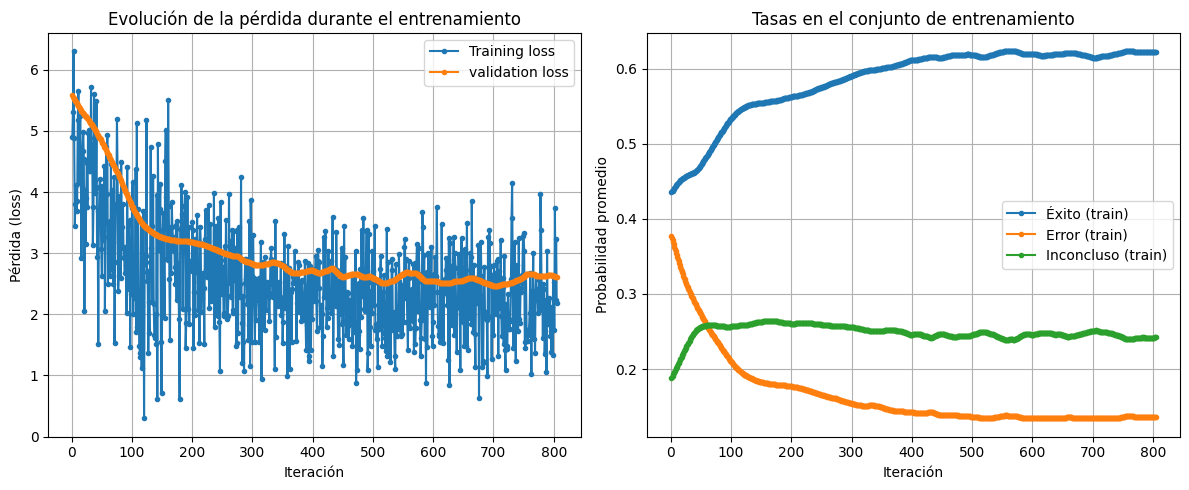

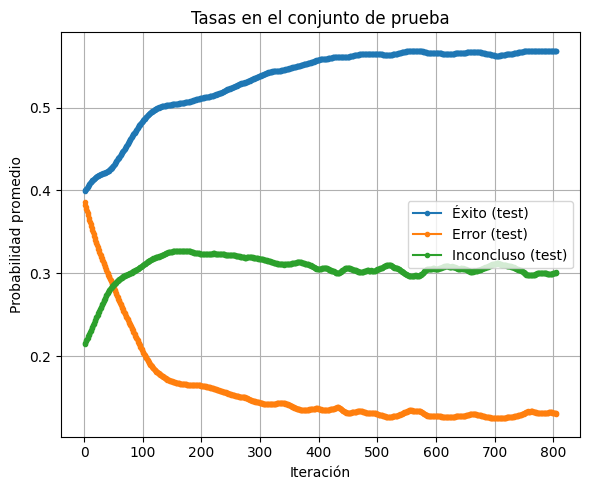

In [13]:
# Visualización de los resultados
plt.figure(figsize=(12,5))

# Evolución de la pérdida
plt.subplot(1,2,1)
plt.plot(range(1, it+1), loss_history, '.-', label="Training loss")
plt.plot(range(1, it+1), val_loss_history, '.-', label="validation loss")
plt.xlabel("Iteración")
plt.ylabel("Pérdida (loss)")
plt.title("Evolución de la pérdida durante el entrenamiento")
plt.grid()
plt.legend()

# Éxito, Error e Inconcluso en train
plt.subplot(1,2,2)
plt.plot(range(1, it+1), train_suc_history, '.-', label="Éxito (train)")
plt.plot(range(1, it+1), train_err_history, '.-', label="Error (train)")
plt.plot(range(1, it+1), train_inc_history, '.-', label="Inconcluso (train)")
plt.xlabel("Iteración")
plt.ylabel("Probabilidad promedio")
plt.title("Tasas en el conjunto de entrenamiento")
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

# Figura para test
plt.figure(figsize=(6,5))

# Éxito, Error e Inconcluso en test
plt.plot(range(1, it+1), test_suc_history, '.-', label="Éxito (test)")
plt.plot(range(1, it+1), test_err_history, '.-', label="Error (test)")
plt.plot(range(1, it+1), test_inc_history, '.-', label="Inconcluso (test)")
plt.xlabel("Iteración")
plt.ylabel("Probabilidad promedio")
plt.title("Tasas en el conjunto de prueba")
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

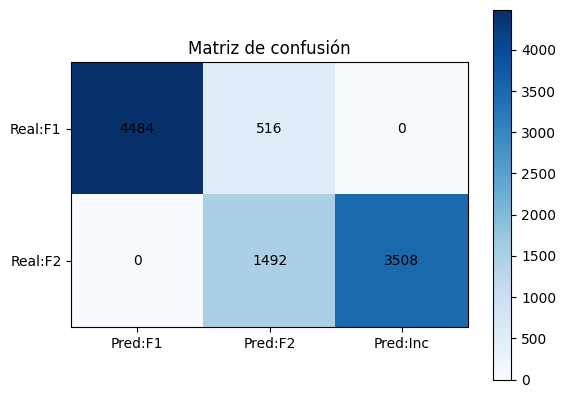

In [14]:
#Matriz de confusión

def predict_label(params, val, actual_label):
    """
    Devuelve la predicción discreta:
      1 => familia 1
      2 => familia 2
      3 => inconcluso


    actual_label se usa para saber qué outcome corresponde a éxito o error.
    """
    probs = get_probabilities(params, val, actual_label)

    p_fam1 = probs[0] + probs[2]
    p_fam2 = probs[1]
    p_inc  = probs[3]

    # Tomamos la mayor de las tres
    idx = np.argmax([p_fam1, p_fam2, p_inc])
    predicted = [1, 2, 3][idx]  # 1=fam1, 2=fam2, 3=inconcluso
    return predicted

def confusion_matrix_inconclusive(params, samples):

    cm = np.zeros((2, 3))
    for (val, actual_label) in samples:
        pred = predict_label(params, val, actual_label)
        row = actual_label - 1  # (1->0, 2->1)
        col = pred - 1          # (1->0, 2->1, 3->2)
        cm[row, col] += 1
    return cm

def plot_confusion_matrix_inconclusive(cm, normalize=False):
    """
    Dibuja la matriz
    """
    cm_display = cm.copy()
    if normalize:
        for i in range(cm_display.shape[0]):
            row_sum = np.sum(cm_display[i, :])
            if row_sum > 0:
                cm_display[i, :] /= row_sum


    fig, ax = plt.subplots()
    im = ax.imshow(cm_display, cmap='Blues', origin='upper')

    # Etiquetas de ejes
    ax.set_xticks([0,1,2])
    ax.set_yticks([0,1])
    ax.set_xticklabels(["Pred:F1","Pred:F2","Pred:Inc"])
    ax.set_yticklabels(["Real:F1","Real:F2"])

    # Texto en cada celda
    for i in range(2):
        for j in range(3):
            val = cm_display[i, j]
            if normalize:
                txt = f"{val*100:.1f}%"
            else:
                txt = f"{val:.0f}"
            ax.text(j, i, txt, ha='center', va='center', color='black')

    plt.colorbar(im, ax=ax)
    plt.title("Matriz de confusión")
    plt.show()


cm_test = confusion_matrix_inconclusive(params, data_test)
plot_confusion_matrix_inconclusive(cm_test, normalize=False)
